# Finding accreted stars in the Milky Way: clues from NIHAO simulations

#### Authors:    
Sven Buder (ANU & ASTRO 3D, sven.buder@anu.edu.au),  
Luka Mijnarends (ANU & ASTRO 3D), and  
Tobias Buck (Uni Heidelberg IWR & ZAH & AIP)

In [1]:
# Preamble for notebook 

# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
    %config Completer.use_jedi = False
except:
    pass

# Basic packages
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import glob
import scipy
import os
import sys
import pandas
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)
import astropy.io.fits as pyfits
from astropy.table import Table, hstack, vstack, join
from astropy.io import fits
from scipy.spatial import ConvexHull
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

# Matplotlib and associated packages for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
from matplotlib.patches import Polygon, Rectangle
from matplotlib import rcParams
rcParams['axes.labelsize'] = 15
rcParams['legend.fontsize'] = 15
rcParams['figure.titlesize'] = 20

panels = [
    'a)','b)','c)',
    'd)','e)','f)',
    'g)','h)','i)',
    'j)','k)','l)',
    'm)','n)','o)',
    'q)','r)','s)',
    't)','u)','v)',
    'w)','x)','y)',
    'z)','aa)','ab)',
    'ac)','ad)','ae)'
]

# 2: DATA: CHEMICAL ABUNDANCES FROM OBSERVATIONS AND SIMULATIONS

## 2.1 Observational data from the GALAH Survey
We already have cross-matched the main catalog and the value-added catalogs via sobject_id.  
The catalog data is provided at https://datacentral.org.au/teamdata/GALAH/public/GALAH_DR3/   
The analysis is described by Buder et al. (2022): https://ui.adsabs.harvard.edu/abs/2021MNRAS.506..150B.  

In [2]:
try:
    obs = Table.read('data/GALAH_DR3_all_joined_v2.fits')
    print('Read in joined file of main_allstar, VAC_ages, and VAC_dynamics.')
except:
    print('Could not read in joined file. Reading in and joining main_allstar, VAC_ages, and VAC_dynamics.')

    try:
        allstar = Table.read('data/GALAH_DR3_main_allstar_v2.fits')
        ages = Table.read('data/GALAH_DR3_VAC_ages_v2.fits')
        dyn = Table.read('data/GALAH_DR3_VAC_dynamics_v2.fits')
        files = join(allstar, dyn, keys = 'sobject_id',metadata_conflicts='silent')

        obs = join(files, ages, keys = 'sobject_id',metadata_conflicts='silent')

        obs.write('data/GALAH_DR3_all_joined_v2.fits',overwrite=True)
        
    except:
        print('Could not find individual GALAH DR3 catalogues.')
        print('Please download main_allstar, VAC_ages, and VAC_dynamics from:')
        print('https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR3/')

Read in joined file of main_allstar, VAC_ages, and VAC_dynamics.


In [3]:
young_age_cutoff = 0.0 # Gyr; since we can hardly measure these ages well - and they are not the focus of this work
fe_h_poor_cutoff = -2.5 # since we can hardly measure lower [Fe/H] well in observations

In [4]:
# Let's apply some basic cuts that allows us to continue with a roughly cleaned set of stars
observation_quality_check_default = (
    (obs['flag_repeat']==0) & # Make sure we only have 1 measurement per star
    (obs['flag_sp'] == 0) & # quality for stellar parameters should be unflagged
    (obs['flag_fe_h'] == 0) & # [Fe/H] value should be an unflagged measurements
    (obs['snr_c2_iraf'] > 25) & # SNR above 25 to get reasonable stellar parameters
    (obs['age_bstep'] > young_age_cutoff) &
    (obs['fe_h'] > fe_h_poor_cutoff) &
    (np.abs(obs['b']) > 10) &
    (obs['best_d_50'] < 4200) &
    np.all([[obs['flag_'+element+'_fe'] == 0] for element in ['Mg']],axis=0)[0]
    # flags for all abundances measurements should be unflagged, here only Mg is tested
)

obs = obs[observation_quality_check_default]
print(len(obs['age_bstep']),' stars left from GALAH DR3 after selection cuts')
nr_stars = str(len(obs['age_bstep']))
if len(nr_stars) > 3:
    nr_stars = nr_stars[:-3]+'\,'+nr_stars[-3:]
np.savetxt('tex_text/nr_stars_in_galah_after_cuts.tex',[nr_stars],fmt='%s')

284327  stars left from GALAH DR3 after selection cuts


In [5]:
# Quantitative assessment of age uncertainties

age_above_8gyr = len(obs[(obs['age_bstep'] > 8)])
age_above_8gyr_above50perc_ageunc = len(obs[((obs['e_age_bstep']/obs['age_bstep']) >= 0.5) & (obs['age_bstep'] > 8)])
age_above_8gyr_above40perc_ageunc = len(obs[((obs['e_age_bstep']/obs['age_bstep']) >= 0.4) & (obs['age_bstep'] > 8)])
age_above_8gyr_above30perc_ageunc = len(obs[((obs['e_age_bstep']/obs['age_bstep']) >= 0.3) & (obs['age_bstep'] > 8)])
age_above_8gyr_below30perc_ageunc = len(obs[((obs['e_age_bstep']/obs['age_bstep']) < 0.3) & (obs['age_bstep'] > 8)])

age_below_8gyr = len(obs[(obs['age_bstep'] <= 8)])
age_below_8gyr_above50perc_ageunc = len(obs[((obs['e_age_bstep']/obs['age_bstep']) >= 0.5) & (obs['age_bstep'] <= 8)])

age_str = str(age_above_8gyr)
np.savetxt('tex_text/age_above_8gyr.tex',[age_str[:-3]+r'\,'+age_str[-3:]+'%'],fmt='%s')
np.savetxt('tex_text/age_above_8gyr_above50perc_ageunc.tex',[str(int(100*age_above_8gyr_above50perc_ageunc/age_above_8gyr))+'\%%'],fmt='%s')
np.savetxt('tex_text/age_above_8gyr_above40perc_ageunc.tex',[str(int(100*age_above_8gyr_above40perc_ageunc/age_above_8gyr))+'\%%'],fmt='%s')
np.savetxt('tex_text/age_above_8gyr_above30perc_ageunc.tex',[str(int(100*age_above_8gyr_above30perc_ageunc/age_above_8gyr))+'\%%'],fmt='%s')
np.savetxt('tex_text/age_above_8gyr_below30perc_ageunc.tex',[str(int(100*age_above_8gyr_below30perc_ageunc/age_above_8gyr))+'\%%'],fmt='%s')

age_str = str(age_below_8gyr)
np.savetxt('tex_text/age_below_8gyr.tex',[age_str[:-3]+r'\,'+age_str[-3:]+'%'],fmt='%s')
np.savetxt('tex_text/age_below_8gyr_above50perc_ageunc.tex',[str(int(100*age_below_8gyr_above50perc_ageunc/age_below_8gyr))+'\%%'],fmt='%s')

print('older than 8Gyr',age_above_8gyr)
print('above 50%',np.round(100*age_above_8gyr_above50perc_ageunc/age_above_8gyr,1))
print('above 40%',np.round(100*age_above_8gyr_above40perc_ageunc/age_above_8gyr,1))
print('above 30%',np.round(100*age_above_8gyr_above30perc_ageunc/age_above_8gyr,1))

print('younger than 8Gyr',age_below_8gyr)
print('above 50%',"{:.2f}".format(100*age_below_8gyr_above50perc_ageunc/age_below_8gyr)+'\%')

older than 8Gyr 100047
above 50% 2.1
above 40% 10.5
above 30% 37.2
younger than 8Gyr 184280
above 50% 18.93\%


## 2.2 Theoretical predictions from a NIHAO Zoom-in simulation
The simulation is part of the NIHAO suite.  
This particular simulation can be retrieved from Tobias Buck.  
It is described in detail in Buck et al. (2021): https://ui.adsabs.harvard.edu/abs/2021MNRAS.508.3365B

In [6]:
try:
    sim = Table.read('data/NIHAO_g8.26e11_simulation_data_220118_original.fits')

    sim['age'] = 14.14018534 - sim['tform']
    sim = sim[
        (sim['Fe_H'] > fe_h_poor_cutoff) & 
        (sim['age'] > young_age_cutoff)
    ]

    # Coordinate transformations

    # simulations come in X, Y, Z. Let's transform this into R, phi, Z
    sim['R']= np.sqrt(sim['x']**2 + sim['y']**2)
    sim['phi'] = np.arctan2(sim['y'], sim['x'])

    sim['V_R'] = (sim['x']*sim['vx'] + sim['y']*sim['vy']) / sim['R']
    sim['V_phi'] = (-sim['y']*sim['vx'] + sim['x']*sim['vy']) / sim['R']
    sim['V_Z'] = sim['vz']


    r_solar = 8.2 # kpc similar to solar radius
    radius = 4.2 # kpc radius similar to GALAH's 95th distance percentile

    # Sphere around R=8kpc with radius of e.g. 1 kpc:
    # sqrt((R-8)**2 + Z**2) < 1 kpc
    sim_solar = (
        (np.sqrt((np.sqrt(sim['x']**2 + sim['y']**2) - r_solar)**2 + sim['z']**2) < radius)
    )
    sim_solar_b10deg = sim_solar & (np.tan(10*np.pi/180) < abs(sim['z']) / abs(np.sqrt(sim['x']**2 + sim['y']**2) - r_solar))

    what_shall_we_use = 'solar_circle_b10deg'

    sim_all = sim
    sim_all_available = True

    if what_shall_we_use == 'solar_circle':
        sim = sim[sim_solar]
    elif what_shall_we_use == 'solar_circle_b10deg':
        sim = sim[sim_solar_b10deg]
        
    sim_footprint = Table()
    for key in sim.keys():
        sim_footprint[key] = np.array(sim[key],dtype=np.float32)
    sim_footprint.write('data/NIHAO_g8.26e11_simulation_data_220118_footprint.fits')

except:
    print('Could not read in full simulation. Therefore using only uploaded observable footprint')
    
    sim = Table.read('data/NIHAO_g8.26e11_simulation_data_220118_footprint.fits')
    sim_all_available = False

# Adjusting the abundance, so that the abundance of stars with 4-5Gyr == 0.0

four_to_five_gyr = (sim['age'] > 4) & (sim['age'] < 5)

shift = dict()

elements = [
    'C_H',
    'N_H',
    'O_H',
    'Ne_H',
    'Mg_H',
    'Al_H',
    'Si_H',
    'P_H',
    'S_H',
    'V_H',
    'Cr_H',
    'Mn_H',
    'Fe_H',
    'Co_H',
    'Ba_H',
]

shift_text = ''

tabular = [
    [r'\begin{tabular}{cccccc}'],
    [r'\hline \hline'],
    [r'Element & Shift & Element & Shift & Element & Shift \\'],
    [r'\hline']
]

for element_index, element in enumerate(elements):
        
    shift[element] = np.round(np.median(sim[element][four_to_five_gyr]),2)

    print(element, -shift[element])
    
    if element_index == len(elements)-1:
        shift_text = shift_text + ' and '

    shift_text = shift_text+'['+element[:-2]+'/H] by '+"{:.2f}".format(-shift[element])
    if element_index != len(elements)-1:
        shift_text = shift_text+', '
        
    sim[element] -= shift[element]
    sim_all[element] -= shift[element]
    
    if element_index % 3 == 0:
        tabular_text = r'{['+element[:-2]+'/H]} & '+"{:.2f}".format(-shift[element])
    elif element_index % 3 > 0:
        tabular_text = tabular_text+r' & {['+element[:-2]+'/H]} & '+"{:.2f}".format(-shift[element])
        if element_index % 3 == 2:
            tabular_text = tabular_text+r' \\'
            tabular.append([tabular_text])
            
tabular.append([r'\hline \hline'])
tabular.append([r'\end{tabular}'])

np.savetxt('tables/tabular_shift_by_4_to_5_gyr.tex',tabular,fmt='%s')
np.savetxt('tex_text/shift_by_4_to_5_gyr_median.tex',[shift_text+'%'],fmt='%s')


Could not read in full simulation. Therefore using only uploaded observable footprint
C_H -0.27
N_H -0.39
O_H -0.26
Ne_H -0.2
Mg_H 0.17
Al_H 0.08
Si_H -0.34
P_H -0.21
S_H -0.29
V_H -0.02
Cr_H -0.19
Mn_H -0.36
Fe_H -0.15
Co_H -0.03
Ba_H -0.7


# 3 DIAGNOSTIC PLOTS: OBSERVATION VS. SIMULATION

# 3.1 Location matters: Full galaxy versus Solar neighborhood

Inspired by Nissen et al. (2010), here we plot different populations in the metal-poor low-/high-alpha halo regime, and observe how overdensities appear in different abundance planes. 

[[-0.9, 0.05000000000000001], [-0.65, 0.025], [-0.65, 0.045], [-0.9, 0.07]]
[[-0.9, 0.05000000000000001], [-0.65, 0.025], [-0.65, 0.045], [-0.9, 0.07]]


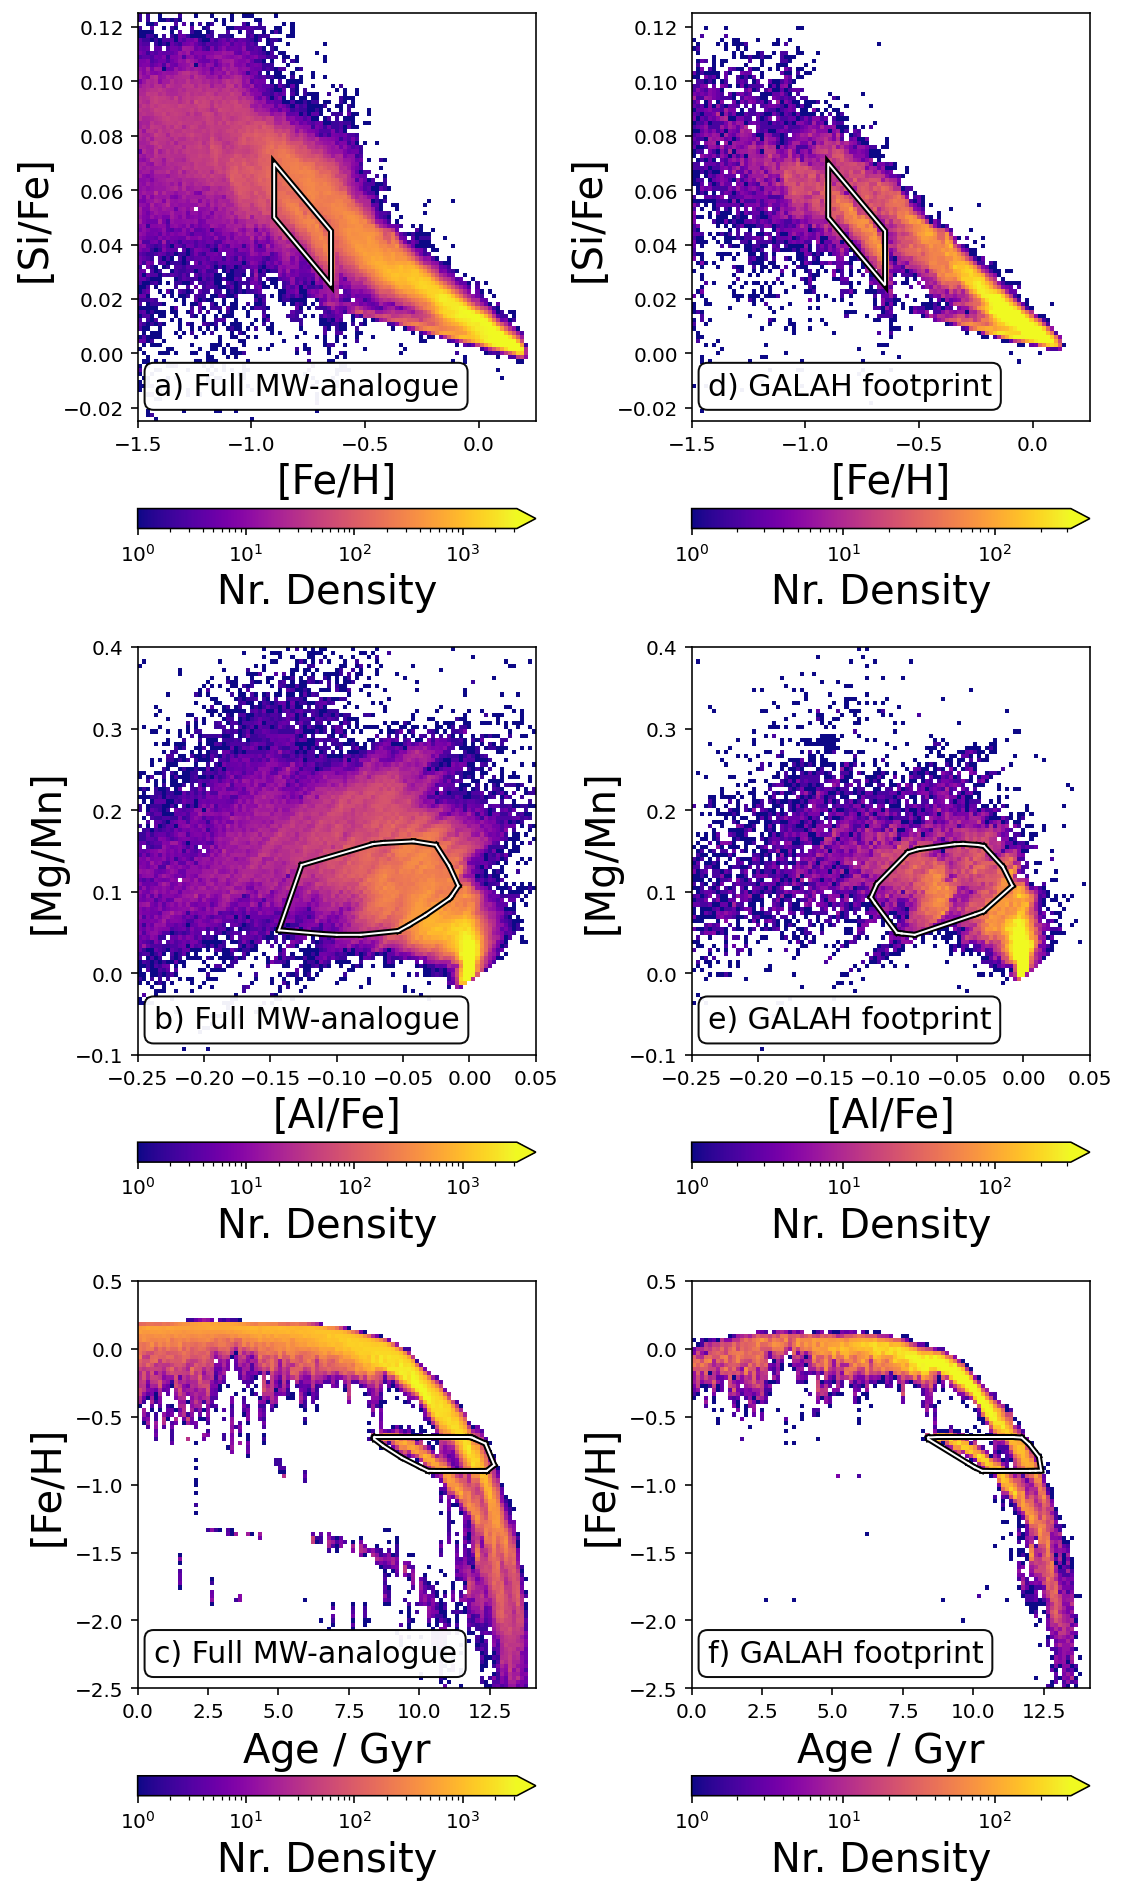

In [7]:
def plot_low_alpha_halo():
        
    f, gs = plt.subplots(3,2,figsize=(8,13.5))
    
    for sim_index, sim_i in enumerate([sim_all, sim]):
    
        if sim_index == 0:
            sim_label = ' Full MW-analogue'
        else:
            sim_label = ' GALAH footprint'
    
        if sim_index == 0:
            vmax = 10**3.5
        else:
            vmax = 10**2.5
    
        lower_feh_limit = -0.9
        upper_feh_limit = -0.65
        slope = -0.1
        intercept1 = -0.04
        intercept2 = -0.02

        select_low_alpha_halo = (
            (sim_i['Fe_H'] > lower_feh_limit) &
            (sim_i['Fe_H'] < upper_feh_limit) &
            (sim_i['Si_H'] - sim_i['Fe_H'] > intercept1 + slope*sim_i['Fe_H']) &
            (sim_i['Si_H'] - sim_i['Fe_H'] < intercept2 + slope*sim_i['Fe_H'])
        )

        ax = gs[0,sim_index]
        ax.text(0.04,0.05,panels[0+3*sim_index]+sim_label,fontsize=15,transform=ax.transAxes,va='bottom',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

        p = ax.hist2d(
            sim_i['Fe_H'],
            sim_i['Si_H'] - sim_i['Fe_H'],
            bins = (np.linspace(-1.5,0.25,100),np.linspace(-0.025,0.125,100)),
            cmin = 1, cmap='plasma',
            norm = LogNorm(vmin = 1, vmax = vmax)
        )
        c = plt.colorbar(p[-1],ax=ax,extend='max',orientation='horizontal')
        c.set_label('Nr. Density', fontsize=20)

        print(            
            [
                [lower_feh_limit,intercept1 + slope*lower_feh_limit],
                [upper_feh_limit,intercept1 + slope*upper_feh_limit],
                [upper_feh_limit,intercept2 + slope*upper_feh_limit],
                [lower_feh_limit,intercept2 + slope*lower_feh_limit]
            ]
        )
        
        polygon = Polygon(
            [
                [lower_feh_limit,intercept1 + slope*lower_feh_limit],
                [upper_feh_limit,intercept1 + slope*upper_feh_limit],
                [upper_feh_limit,intercept2 + slope*upper_feh_limit],
                [lower_feh_limit,intercept2 + slope*lower_feh_limit]
            ], 
            True,
            fill=False,
            edgecolor = 'k',
            lw = 3
        )
        ax.add_patch(polygon)
        polygon = Polygon(
            [
                [lower_feh_limit,intercept1 + slope*lower_feh_limit],
                [upper_feh_limit,intercept1 + slope*upper_feh_limit],
                [upper_feh_limit,intercept2 + slope*upper_feh_limit],
                [lower_feh_limit,intercept2 + slope*lower_feh_limit]
            ], 
            True,
            fill=False,
            edgecolor = 'w',
            lw = 1
        )
        ax.add_patch(polygon)


        ax.set_xlabel('[Fe/H]', fontsize=20)
        ax.set_ylabel('[Si/Fe]', fontsize=20)

        # [Al/Fe] vs. [Mg/Mn]
        ax = gs[1,sim_index]
        ax.text(0.04,0.05,panels[1+3*sim_index]+sim_label,fontsize=15,transform=ax.transAxes,va='bottom',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

        p = ax.hist2d(
            sim_i['Al_H'] - sim_i['Fe_H'],
            sim_i['Mg_H'] - sim_i['Mn_H'],
            bins = (np.linspace(-0.25,0.05,100),np.linspace(-0.1,0.4,100)),
            cmin = 1, cmap='plasma',
            norm = LogNorm(vmin = 1, vmax = vmax)
        )
        c = plt.colorbar(p[-1],ax=ax,extend='max',orientation='horizontal')
        c.set_label('Nr. Density', fontsize=20)

        sim_al_fe = sim_i['Al_H'][select_low_alpha_halo] - sim_i['Fe_H'][select_low_alpha_halo]
        sim_mg_mn = sim_i['Mg_H'][select_low_alpha_halo] - sim_i['Mn_H'][select_low_alpha_halo]
        hull = ConvexHull(
            np.array([
                sim_al_fe,
                sim_mg_mn
            ]).T
        )
        for simplex in hull.simplices:
            ax.plot(sim_al_fe[simplex], sim_mg_mn[simplex], 'k', lw=3)
        for simplex in hull.simplices:
            ax.plot(sim_al_fe[simplex], sim_mg_mn[simplex], 'w', lw=1)

        ax.set_xlabel('[Al/Fe]',fontsize=20)
        ax.set_ylabel('[Mg/Mn]',fontsize=20)

        # Age vs. [Fe/H]
        ax = gs[2,sim_index]
        ax.text(0.04,0.05,panels[2+3*sim_index]+sim_label,fontsize=15,transform=ax.transAxes,va='bottom',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

        p = ax.hist2d(
            sim_i['age'],
            sim_i['Fe_H'],
            bins = (np.linspace(young_age_cutoff,14.14,100),np.linspace(fe_h_poor_cutoff,.5,100)),
            cmin = 1, cmap='plasma',
            norm = LogNorm(vmin = 1, vmax = vmax)
        )
        c = plt.colorbar(p[-1],ax=ax,extend='max',orientation='horizontal')
        c.set_label('Nr. Density', fontsize=20)

        sim_al_fe = sim_i['age'][select_low_alpha_halo]
        sim_mg_mn = sim_i['Fe_H'][select_low_alpha_halo]
        hull = ConvexHull(
            np.array([
                sim_al_fe,
                sim_mg_mn
            ]).T
        )
        for simplex in hull.simplices:
            ax.plot(sim_al_fe[simplex], sim_mg_mn[simplex], 'k', lw=3)
        for simplex in hull.simplices:
            ax.plot(sim_al_fe[simplex], sim_mg_mn[simplex], 'w', lw=1)

        ax.set_xlabel(r'$\mathrm{Age}~/~\mathrm{Gyr}$',fontsize=20)
        ax.set_ylabel('[Fe/H]',fontsize=20)
        
    plt.tight_layout(h_pad=0)

    plt.savefig('figures/low_alpha_halo_convex_hull.png',dpi=200,bbox_inches='tight')

plot_low_alpha_halo()

# 3.2 Abundance trends: [Fe/H] vs. [X/Fe]

The simulation traces the chemical evolution of the following elements:  
H, He, C, N, O, Ne, Mg, Al, Si, P, S, V, Cr, Mn, Fe, Co, Ba.  

Of these, the following ten are also reported by the GALAH survey:  
C, O, Mg, Al, Si, V, Cr, Mn, Co and Ba

/Users/buder/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(
/Users/buder/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/buder/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(
/Users/buder/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/buder/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(
/Users/buder/op

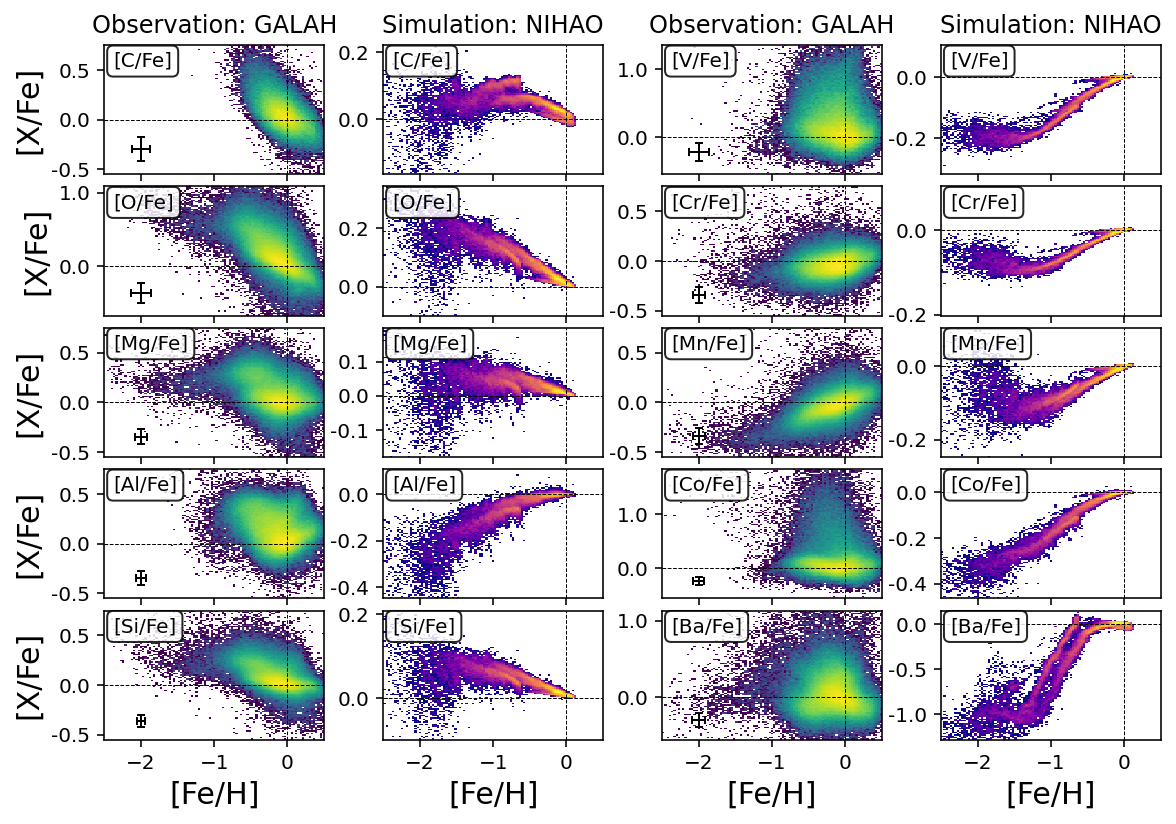

Caption: Distribution of elemental abundances [X/Fe] versus [Fe/H] for the ten elements overlapping between GALAH and NIHAO. Observations are shown in first and third row with simulated distributions in the row next to them. Color maps are showing the logarithmic density distributions with brightest colors indicating highest densities. For better visibility, plot ranges are adjusted to the data rather than to be equal among each panel. Dashed lines indicate Solar values.


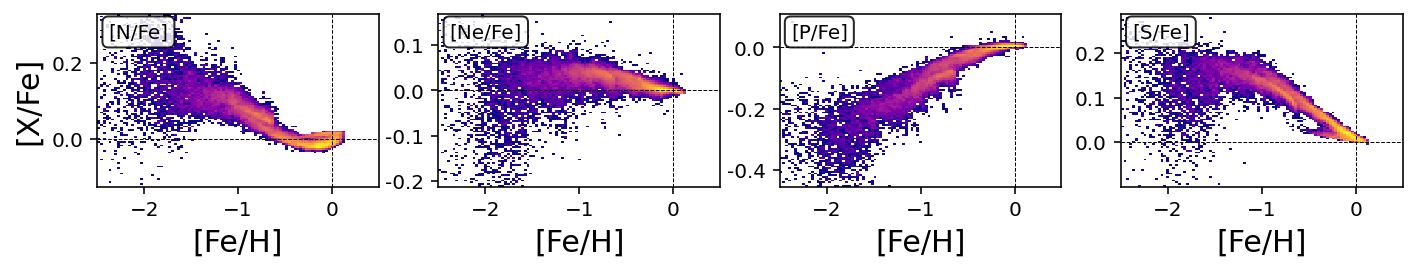

In [8]:
# Let's plot an overview of all these 10 elements:

def plot_abundance_overview_observations_simulations(sim, sharey=False):
    """
    Distribution of elemental abundances [X/Fe] versus [Fe/H] 
    for the ten elements overlapping between GALAH and NIHAO.
    
    Color maps are showing the logarithmic density distributions with brightest colors indicating highest densities.
    For better visibility, plot ranges are adjusted to the data rather than to be equal among each panel. 
    Dashed lines indicate Solar values.
    
    INPUT:
    sharey = False/True: Shall the abundances [X/Fe] be plotted on the same y-axis range?
    
    OUTPUT:
    plt.savefig() with or without shary
    
    """

    f, gs = plt.subplots(5,4,sharex=True,sharey=sharey,figsize=(8.27, 11.69/2.))

    for element_index, element in enumerate(['C','O','Mg','Al','Si','V','Cr','Mn','Co','Ba']):
        
        # Observations are shown in first and third row with simulated distributions in the row next to them. 
        if element_index <= 4:
            ax_obs = gs[element_index,0]
            ax_sim = gs[element_index,1]
        else:
            ax_obs = gs[element_index-5,2]
            ax_sim = gs[element_index-5,3]
            
        ax_obs.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax_sim.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

        ######
        # Panels with observations
        ######
        
        # We apply our usual quality checks, but here for each element individually
        observation_quality_check = (
            (obs['flag_'+element+'_fe'] == 0) &
            (obs['fe_h'] >= fe_h_poor_cutoff)
        )
        
        # For better visibility, we adjust the y-ranges of the plots to go between the 0.5th and 99.5th percentiles and add another +- 0.1 dex (but at least -0.55 and 0.75)
        xfe_obs = obs[element+'_fe'][observation_quality_check]
        percentiles_obs = np.percentile(xfe_obs,q=[0.5,99.5])
        yminmax = (np.min([-0.55,percentiles_obs[0]-0.1]), np.max([0.75,percentiles_obs[-1]+0.1]))

        ax_obs.hist2d(
            obs['fe_h'][observation_quality_check],
            obs[element+'_fe'][observation_quality_check],
            bins=(np.linspace(fe_h_poor_cutoff,0.5,100),np.linspace(yminmax[0],yminmax[1],100)),
            cmin = 1,
            norm = LogNorm(),
            zorder=2
        )
        
        xvals = np.median(obs['e_'+element+'_fe'][observation_quality_check])
        yvals = np.median(obs['e_'+element+'_fe'][observation_quality_check])
        ax_obs.errorbar(
            [-2.0],
            [yminmax[0]+0.1*(yminmax[1]-yminmax[0])+yvals],
            xerr = xvals,
            yerr = yvals,
            capsize = 4, lw=3, c='w'
        )
        ax_obs.errorbar(
            [-2.0],
            [yminmax[0]+0.1*(yminmax[1]-yminmax[0])+yvals],
            xerr = xvals,
            yerr = yvals,
            capsize = 2, lw=1, c='k'
        )
        
        
        ######
        # Panels with simulations
        ######
        
        simulation_hack = (
            (sim['Fe_H'] > fe_h_poor_cutoff) # This is just to make sure that the plot ranges do not explode...
        )
        # For better visibility, we adjust the y-ranges of the plots to go between the 0.5th and 99.5th percentiles and add another +- 0.1 dex
        sim_xfe = sim[element+'_H'][simulation_hack] - sim['Fe_H'][simulation_hack]
        percentiles_sim = np.percentile(sim_xfe,q=[0.5,99.5])
        
        ax_sim.hist2d(
            sim['Fe_H'][simulation_hack],
            sim[element+'_H'][simulation_hack] - sim['Fe_H'][simulation_hack],
            bins=(np.linspace(fe_h_poor_cutoff,0.5,100),np.linspace(percentiles_sim[0]-0.1,percentiles_sim[-1]+0.1,100)),
            cmin = 1,
            norm = LogNorm(),
            cmap = 'plasma'
        )

        # Add text with [X/Fe]
        ax_obs.text(0.04,0.95,'['+element+'/Fe]',transform=ax_obs.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
        ax_sim.text(0.04,0.95,'['+element+'/Fe]',transform=ax_sim.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))

        # Add Solar value lines at (0,0)
        ax_obs.axhline(0,lw=0.5,ls='dashed',c='k')
        ax_sim.axhline(0,lw=0.5,ls='dashed',c='k')
        ax_obs.axvline(0,lw=0.5,ls='dashed',c='k')
        ax_sim.axvline(0,lw=0.5,ls='dashed',c='k')
        
        # Add titles and x-/y-labels
        if element_index in [0,5]:
            ax_obs.set_title('Observation: GALAH')
            ax_sim.set_title('Simulation: NIHAO')
        if element_index in [4,9]:
            ax_obs.set_xlabel('[Fe/H]')
            ax_sim.set_xlabel('[Fe/H]')
        if element_index <= 4:        
            ax_obs.set_ylabel('[X/Fe]')
   
    plt.tight_layout(h_pad=0,w_pad=0.3)
    if sharey:
        plt.savefig('figures/Overview_FeH_XFe_Obs_Sim_sharey.png',bbox_inches='tight',dpi=200)
    else:
        plt.savefig('figures/Overview_FeH_XFe_Obs_Sim.png',bbox_inches='tight',dpi=200)
    plt.show()
    plt.close()

def plot_abundance_overview_only_simulations(sim, sharey=False):

    f, gs = plt.subplots(1,4,sharex=True,sharey=sharey,figsize=(10, 2))

    for element_index, element in enumerate(['N','Ne','P','S']):

        # Observations are shown in first and third row with simulated distributions in the row next to them. 
        ax_sim = gs[element_index]
            
        ax_sim.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

        ######
        # Panels with simulations
        ######
        
        simulation_hack = (
            (sim['Fe_H'] > fe_h_poor_cutoff) # This is just to make sure that the plot ranges do not explode...
        )
        # For better visibility, we adjust the y-ranges of the plots to go between the 0.5th and 99.5th percentiles and add another +- 0.1 dex
        sim_xfe = sim[element+'_H'][simulation_hack] - sim['Fe_H'][simulation_hack]
        percentiles_sim = np.percentile(sim_xfe,q=[0.5,99.5])
        
        ax_sim.hist2d(
            sim['Fe_H'][simulation_hack],
            sim[element+'_H'][simulation_hack] - sim['Fe_H'][simulation_hack],
            bins=(np.linspace(fe_h_poor_cutoff,0.5,100),np.linspace(percentiles_sim[0]-0.1,percentiles_sim[-1]+0.1,100)),
            cmin = 1,
            norm = LogNorm(),
            cmap = 'plasma'
        )

        # Add text with [X/Fe]
        ax_sim.text(0.04,0.95,'['+element+'/Fe]',transform=ax_sim.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))

        # Add Solar value lines at (0,0)
        ax_sim.axhline(0,lw=0.5,ls='dashed',c='k')
        ax_sim.axvline(0,lw=0.5,ls='dashed',c='k')
        
        ax_sim.set_xlabel('[Fe/H]')
        if element_index == 0:        
            ax_sim.set_ylabel('[X/Fe]')
   
    plt.tight_layout(h_pad=0,w_pad=0.3)
    if sharey:
        plt.savefig('figures/Overview_FeH_XFe_Sim_only_sharey.png',bbox_inches='tight',dpi=200)
    else:
        plt.savefig('figures/Overview_FeH_XFe_Sim_only.png',bbox_inches='tight',dpi=200)

plot_abundance_overview_observations_simulations(sim, sharey=False)

plot_abundance_overview_only_simulations(sim, sharey=False)

print('Caption: Distribution of elemental abundances [X/Fe] versus [Fe/H] for the ten elements overlapping between GALAH and NIHAO. Observations are shown in first and third row with simulated distributions in the row next to them. Color maps are showing the logarithmic density distributions with brightest colors indicating highest densities. For better visibility, plot ranges are adjusted to the data rather than to be equal among each panel. Dashed lines indicate Solar values.')

## 3.3 Abundance-abundance plots: [Al/Fe] vs. [Mg/Mn]

/Users/buder/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/buder/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


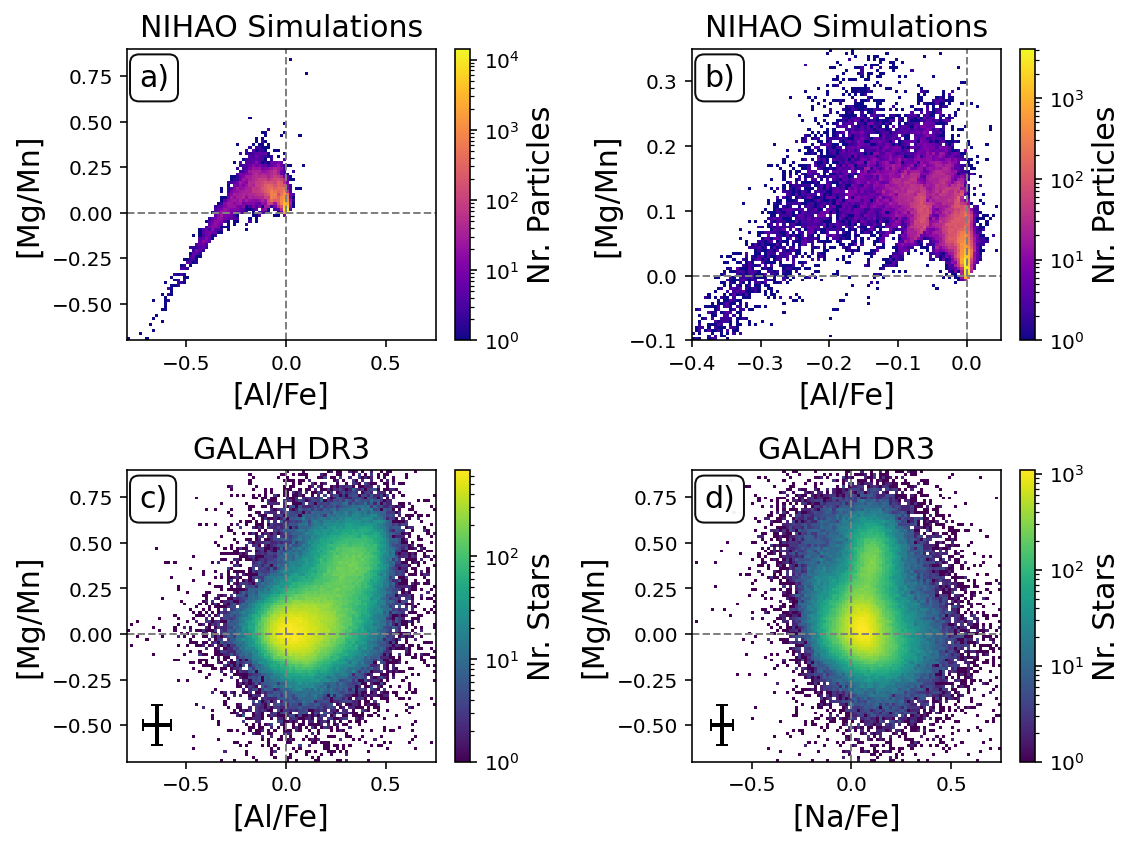

In [9]:
f, gs = plt.subplots(2,2,figsize=(8,6))#,sharex=True,sharey=True)

# Simulation: axes equal to observation plots for comparison
ax = gs[0,0]
ax.text(0.04,0.95,panels[0],fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

p, x, y, s = ax.hist2d(
    sim['Al_H']-sim['Fe_H'],
    sim['Mg_H']-sim['Mn_H'],
    bins = (np.linspace(-0.8, 0.75, 100), np.linspace(-0.7, 0.9, 100)),
    cmin = 1,
    norm = LogNorm()
);
c = plt.colorbar(s, ax=ax)
c.set_label('Nr. Particles',fontsize=15)
ax.set_xlabel('[Al/Fe]',fontsize=15)
ax.set_ylabel('[Mg/Mn]',fontsize=15)
ax.set_title('NIHAO Simulations',fontsize=15)
s.set_cmap('plasma')
ax.axvline(0, color='grey',lw=1,ls='dashed')
ax.axhline(0, color = 'grey',lw=1,ls='dashed')

observation_quality_check_default = (
    np.all([[obs['flag_'+element+'_fe'] == 0] for element in ['Mg','Mn','Al']],axis=0)[0] # flags for all abundances measurements should be unflagged, here only Mg is tested
)

# Simulation: axes adjusted to show detail of plot
ax = gs[0,1]
ax.text(0.04,0.95,panels[1],fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
p, x, y, s = ax.hist2d(
    sim['Al_H']-sim['Fe_H'],
    sim['Mg_H']-sim['Mn_H'],
    bins = (np.linspace(-0.40,0.05,100),np.linspace(-0.10,0.35, 100)),
    cmin = 1,
    norm = LogNorm()
);
c = plt.colorbar(s, ax=ax)
c.set_label('Nr. Particles',fontsize=15)
ax.set_xlabel('[Al/Fe]',fontsize=15)
ax.set_ylabel('[Mg/Mn]',fontsize=15)
s.set_cmap('plasma')
ax.set_title('NIHAO Simulations',fontsize=15)
ax.axvline(0, color='grey',lw=1,ls='dashed')
ax.axhline(0, color = 'grey',lw=1,ls='dashed')

# Observation: against Al to compare to simulations
ax = gs[1,0]
ax.text(0.04,0.95,panels[2],fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
p, x, y, s = ax.hist2d(
    obs['Al_fe'][observation_quality_check_default],
    obs['Mg_fe'][observation_quality_check_default]-obs['Mn_fe'][observation_quality_check_default],
    bins = (np.linspace(-0.8, 0.75, 100), np.linspace(-0.7, 0.9, 100)),
    cmin = 1,
    norm = LogNorm()
);
c = plt.colorbar(s,  ax=ax)
c.set_label('Nr. Stars',fontsize=15)
ax.set_xlabel('[Al/Fe]',fontsize=15)
ax.set_ylabel('[Mg/Mn]',fontsize=15)
ax.set_title('GALAH DR3',fontsize=15)
ax.axvline(0, color='grey',lw=1,ls='dashed')
ax.axhline(0, color = 'grey',lw=1,ls='dashed')
s.set_cmap('viridis')

ax.errorbar(
    [-0.65],
    [-0.5],
    xerr = np.median(obs['e_Al_fe'][observation_quality_check_default]),
    yerr = np.median(
        np.sqrt(
            obs['e_Mg_fe'][observation_quality_check_default]**2+
            obs['e_Mn_fe'][observation_quality_check_default]**2
       )
    ),
    capsize = 3, lw=2, c='k'
)

observation_quality_check_default = (
    np.all([[obs['flag_'+element+'_fe'] == 0] for element in ['Mg','Mn','Na']],axis=0)[0] # flags for all abundances measurements should be unflagged, here only Mg is tested
)

# Observation: against Na instead of Al, due to better observations 
ax = gs[1,1]
ax.text(0.04,0.95,panels[3],fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
p, x, y, s = ax.hist2d(
    obs['Na_fe'][observation_quality_check_default],
    obs['Mg_fe'][observation_quality_check_default]-obs['Mn_fe'][observation_quality_check_default],
    bins = (np.linspace(-0.8, 0.75, 100), np.linspace(-0.7, 0.9, 100)),
    cmin = 1,
    norm = LogNorm()
);
c = plt.colorbar(s, ax=ax)
c.set_label('Nr. Stars',fontsize=15)
ax.set_xlabel('[Na/Fe]',fontsize=15)
ax.set_ylabel('[Mg/Mn]',fontsize=15)
ax.set_title('GALAH DR3',fontsize=15)
s.set_cmap('viridis')
ax.axvline(0, color='grey',lw=1,ls='dashed')
ax.axhline(0, color = 'grey',lw=1,ls='dashed')

ax.errorbar(
    [-0.65],
    [-0.5],
    xerr = np.median(obs['e_Na_fe'][observation_quality_check_default]),
    yerr = np.median(
        np.sqrt(
            obs['e_Mg_fe'][observation_quality_check_default]**2+
            obs['e_Mn_fe'][observation_quality_check_default]**2
       )
    ),
    capsize = 3, lw=2, c='k'
)

observation_quality_check_default = (
    np.all([[obs['flag_'+element+'_fe'] == 0] for element in ['Mg','Mn','Al']],axis=0)[0] # flags for all abundances measurements should be unflagged, here only Mg is tested
)

plt.tight_layout()

plt.savefig('figures/mgmn_alfe.png', dpi=200,bbox_inches='tight')

# 4 A NEW (?) ANGLE: AGE-ABUNDANCE-DISTRIBUTIONS

## 4.1 Clearly separated sequences in the age-[Fe/H] relation of the Milky Way analogue

In [10]:
# Selecting the stars that are members of the topmost population of the simulated plot (BLUE)
age_feh_sequences = dict()

age_feh_sequences['1'] = (
    (sim['Fe_H'] > -0.2) |
    ((sim['Fe_H'] > -1.) & (sim['age'] < 7)) |
    (10**(sim['Fe_H']+0.35) > 2.0 - 0.15*(sim['age']))
)

# The middle stream - most likely accreted (RED)
age_feh_sequences['2'] = (
    ~ age_feh_sequences['1'] &
    (sim['age'] > 6) &
    (10**(sim['Fe_H']+0.45) > 1.87 - 0.15*(sim['age']))
)

# The bottom, small stream (PURPLE)
age_feh_sequences['3'] = (
    (sim['age'] > 10) &
    (~age_feh_sequences['1']) &
    (~age_feh_sequences['2'])
)

colors = ['C0','r','purple']
cmaps = ['Blues','Reds','Purples']

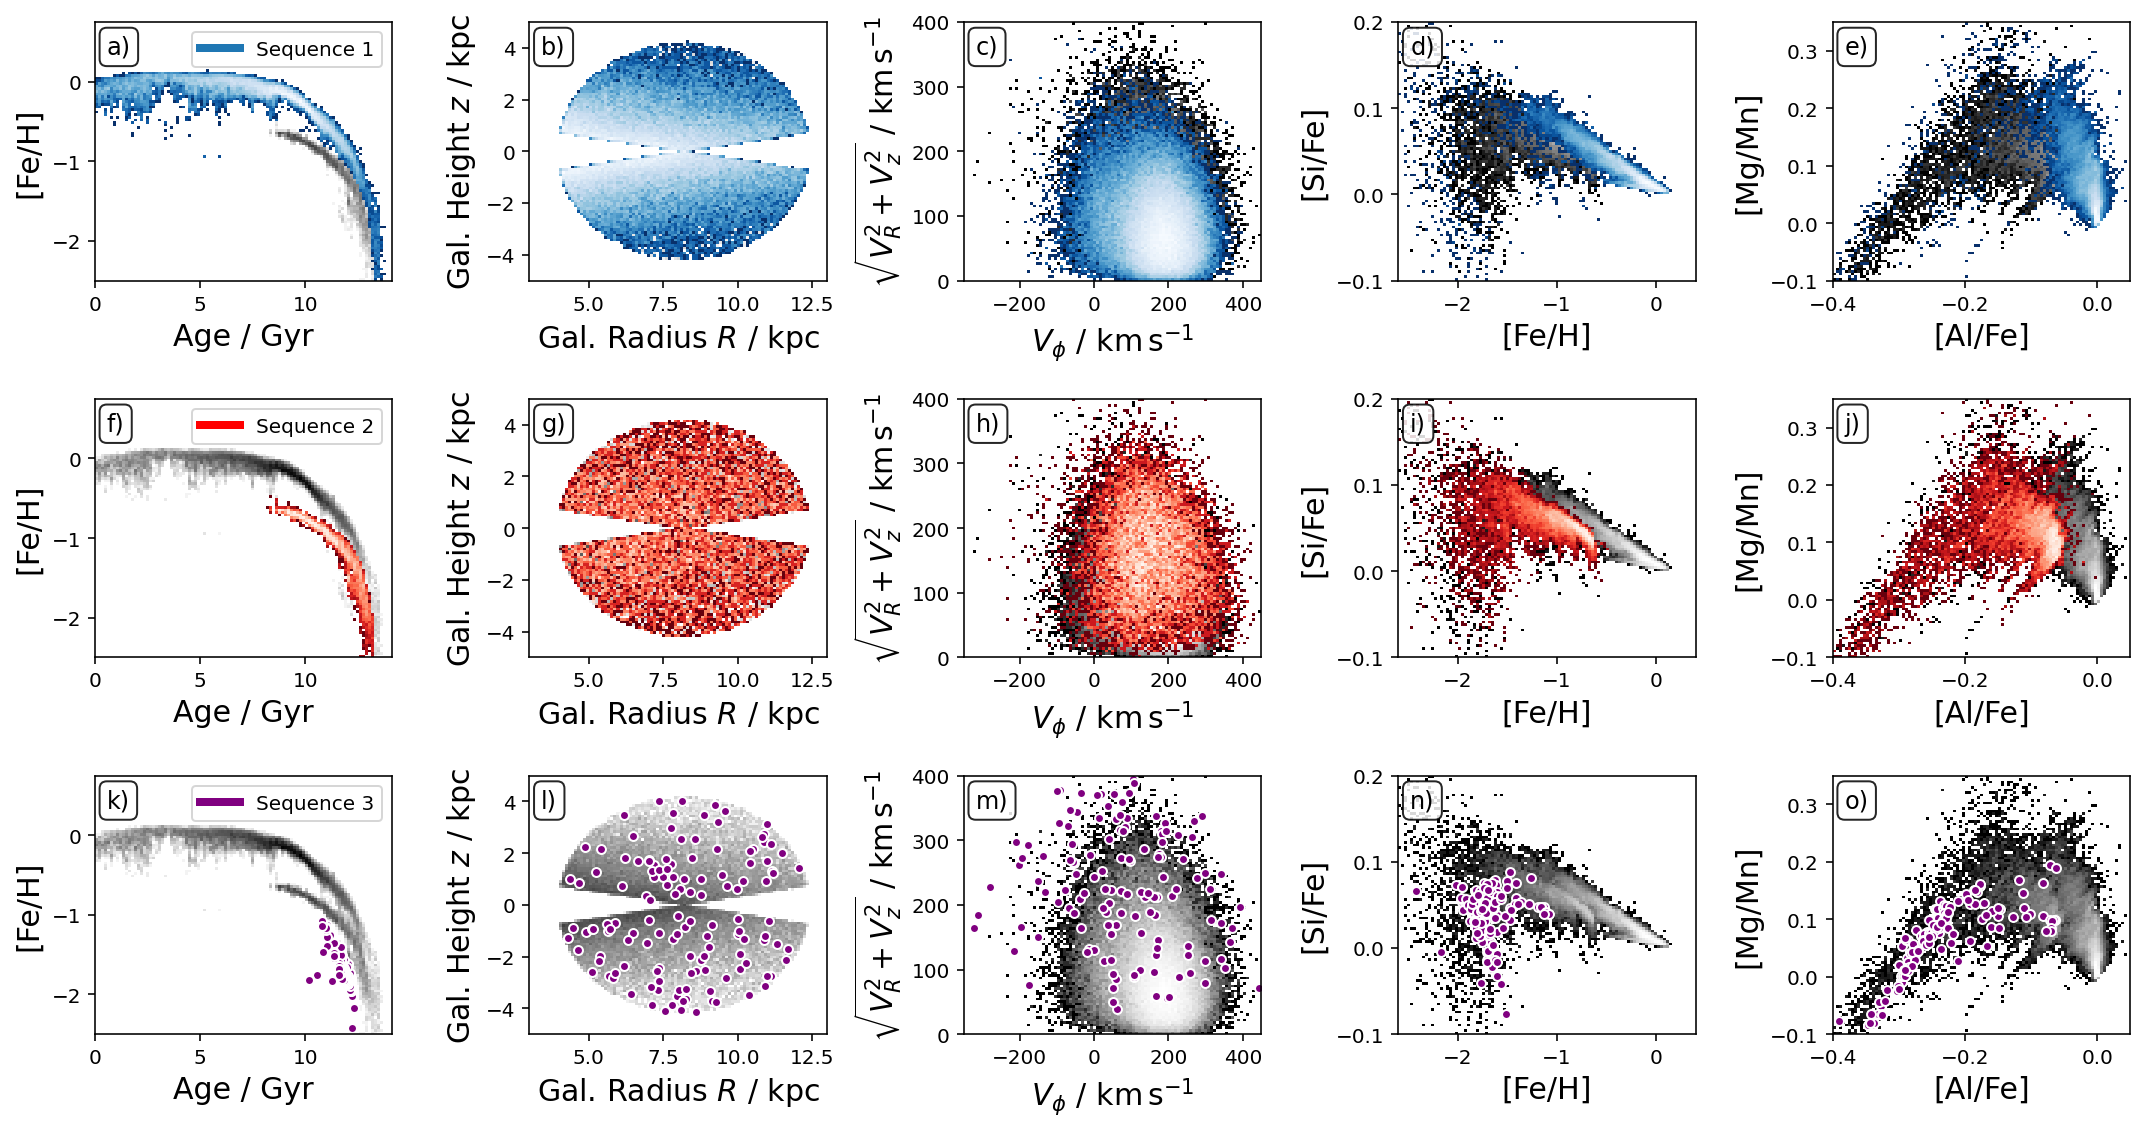

In [11]:
def plot_Alfe_mgmn_dissection_sim(save=False):

    selection_text = ''
    
    f, gs = plt.subplots(3,5,figsize=(15,8))

    for index, selection in enumerate([age_feh_sequences['1'],age_feh_sequences['2'],age_feh_sequences['3']]):

        
        
        # Age-Metallicity-Relation

        x_bins = np.linspace(young_age_cutoff,14.14,100)
        y_bins = np.linspace(fe_h_poor_cutoff,0.75,100)

        panelsx = ['a)','f)','k)']
        
        ax = gs[index,0]
        ax.set_xlabel('Age / Gyr')
        ax.set_ylabel('[Fe/H]')
        ax.text(0.04,0.95,panelsx[index],transform=ax.transAxes,fontsize=12,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))

        p, x, y, s = ax.hist2d(
            # Ensuring plots are over age, and consistent with b_age_step
            sim['age'],
            sim['Fe_H'],
            bins = (x_bins, y_bins),
            cmin = 1,cmap='Greys',
            norm = LogNorm()
        );
        if len(sim['Al_H'][selection]) > 1000:
            p, x, y, s = ax.hist2d(
                sim['age'][selection],
                sim['Fe_H'][selection],
                bins = (x_bins, y_bins),
                cmin = 1,cmap=cmaps[index]+'_r',
                norm = LogNorm()
            )
        else:
            ax.scatter(
                sim['age'][selection],
                sim['Fe_H'][selection],
                c = colors[index], s = 20,
                edgecolor = 'w', lw=1
            )

        legend_elements = [
            Line2D([0], [0], color=colors[index], lw=4, label='Sequence '+str(index+1))
        ]
        ax.legend(handles=legend_elements, loc='upper right', fontsize=10)        
        
        # Galactic Height v Galactic Radius 
        
        panelsx = ['b)','g)','l)']

        # x_bins = np.linspace(0,50,50)
        # y_bins = np.linspace(-25,25,50)
        x_bins = np.linspace(3,13,100)
        y_bins = np.linspace(-5,5,100)

        # Defining galactic height 
        X = np.sqrt(sim['x']**2+sim['y']**2)
        Y = sim['z']
        
        ax = gs[index,1]
        ax.text(0.04,0.95,panelsx[index],transform=ax.transAxes,fontsize=12,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
        ax.set_xlabel('Gal. Radius $R$ / kpc')
        ax.set_ylabel('Gal. Height $z$ / kpc')
            
        p = ax.hist2d(
            X,
            Y,
            bins = (x_bins, y_bins),
            cmin = 1, cmap='Greys', alpha = 0.75,
            norm = LogNorm()
        )
        if len(sim['Al_H'][selection]) > 1000:
            p = ax.hist2d(
                X[selection],
                Y[selection],
                bins=(x_bins,y_bins),
                cmin=1,cmap=cmaps[index]+'_r',
                norm=LogNorm()
            )
        else:
            ax.scatter(
                X[selection],
                Y[selection],
                c = colors[index], s = 20,
                edgecolor = 'w', lw=1
            )

        
        x_bins = np.linspace(-350,450,100)
        y_bins = np.linspace(0,400,100)

        panelsx = ['c)','h)','m)']

        ax = gs[index,2]
        ax.text(0.04,0.95,panelsx[index],transform=ax.transAxes,fontsize=12,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
        ax.set_xlabel(r'$V_\phi~/~\mathrm{km\,s^{-1}}$')
        ax.set_ylabel(r'$\sqrt{V_R^2+V_z^2}~/~\mathrm{km\,s^{-1}}$')

        p = ax.hist2d(
            sim['V_phi'],
            np.sqrt(sim['V_R']**2+sim['V_Z']**2),
            bins = (x_bins, y_bins),
            cmin = 1, cmap='Greys_r',
            norm = LogNorm()
        )
        if len(sim['Al_H'][selection]) > 1000:
            p = ax.hist2d(
                sim['V_phi'][selection],
                np.sqrt(sim['V_R'][selection]**2 + sim['V_Z'][selection]**2),
                bins = (x_bins, y_bins),
                cmin = 1, cmap=cmaps[index]+'_r',
                norm = LogNorm()
            )
        else:
            ax.scatter(
                sim['V_phi'][selection],
                np.sqrt(sim['V_R'][selection]**2 + sim['V_Z'][selection]**2),
                c = colors[index], s = 20,
                edgecolor = 'w', lw=1
            )
            
        v_phi_percentile = np.round(np.percentile(sim['V_phi'][selection],q=[16,50,84]),-1)
        perc_diff = np.diff(v_phi_percentile)            
        np.savetxt('tex_text/v_phi_sequence_'+str(index+1)+'.tex',[r'$V_\phi = '+str(int(v_phi_percentile[1]))+'_{-'+str(int(perc_diff[0]))+'}^{+'+str(int(perc_diff[1]))+'}\,\mathrm{kpc\,km\,s^{-1}}$%'],fmt='%s')
            
        x_bins = np.linspace(fe_h_poor_cutoff-0.1,0.4,100)
        y_bins = np.linspace(-0.10,0.20,100)

        panelsx = ['d)','i)','n)']
        
        ax = gs[index,3]
        ax.text(0.04,0.95,panelsx[index],transform=ax.transAxes,fontsize=12,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
        ax.set_xlabel('[Fe/H]')
        ax.set_ylabel('[Si/Fe]')

        p = ax.hist2d(
            sim['Fe_H'],
            sim['Si_H'] - sim['Fe_H'],
            bins = (x_bins, y_bins),
            cmin = 1, cmap='Greys_r',
            norm = LogNorm()
        )
        if len(sim['Al_H'][selection]) > 1000:
            p = ax.hist2d(
                sim['Fe_H'][selection],
                sim['Si_H'][selection] - sim['Fe_H'][selection],
                bins = (x_bins, y_bins),
                cmin = 1, cmap=cmaps[index]+'_r',
                norm = LogNorm()
            )
        else:
            ax.scatter(
                sim['Fe_H'][selection],
                sim['Si_H'][selection] - sim['Fe_H'][selection],
                c = colors[index], s = 20,
                edgecolor = 'w', lw=1
            )
            

            
        # [Al/Fe] vs. [Mg/Mn]
        
        x_bins = np.linspace(-0.40,0.05,100)
        y_bins = np.linspace(-0.10,0.35,100)

        panelsx = ['e)','j)','o)']
        
        ax = gs[index,4]
        ax.text(0.04,0.95,panelsx[index],transform=ax.transAxes,fontsize=12,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
        ax.set_xlabel('[Al/Fe]')
        ax.set_ylabel('[Mg/Mn]')

        p = ax.hist2d(
            sim['Al_H'] - sim['Fe_H'],
            sim['Mg_H'] - sim['Mn_H'],
            bins = (x_bins, y_bins),
            cmin = 1, cmap='Greys_r',
            norm = LogNorm()
        )
        if len(sim['Al_H'][selection]) > 1000:
            p = ax.hist2d(
                sim['Al_H'][selection] - sim['Fe_H'][selection],
                sim['Mg_H'][selection] - sim['Mn_H'][selection],
                bins = (x_bins, y_bins),
                cmin = 1, cmap=cmaps[index]+'_r',
                norm = LogNorm()
            )
        else:
            ax.scatter(
                sim['Al_H'][selection] - sim['Fe_H'][selection],
                sim['Mg_H'][selection] - sim['Mn_H'][selection],
                c = colors[index], s = 20,
                edgecolor = 'w', lw=1
            )
            
        length = str(len(sim['Al_H'][selection]))
        if len(length) > 6:
            length = length[:-6]+'\,'+length[-6:-3]+'\,'+length[-3:]
        elif len(length) > 3:
            length = length[-6:-3]+'\,'+length[-3:]
            
        full_length = str(len(sim['Al_H']))
        if len(full_length) > 6:
            full_length = full_length[:-6]+'\,'+full_length[-6:-3]+'\,'+full_length[-3:]
        elif len(full_length) > 3:
            full_length = full_length[-6:-3]+'\,'+full_length[-3:]

        if index == 0:
            selection_text = selection_text+length+' particles for Sequence 1, '
            np.savetxt('tex_text/sequence_1_fraction.tex',[str(int(np.round(100*len(sim['Al_H'][selection])/len(sim['Al_H']))))+'\%%'],fmt='%s')
        if index == 1:
            selection_text = selection_text+length+' particles for Sequence 2, and '
            np.savetxt('tex_text/sequence_2_fraction.tex',[str(int(np.round(100*len(sim['Al_H'][selection])/len(sim['Al_H']))))+'\%%'],fmt='%s')
        if index == 2:
            selection_text = selection_text+length+' particles for Sequence 3 of the '+full_length+' particles in the footprint%'
            np.savetxt('tex_text/sequence_3_fraction.tex',["{:.1f}".format(np.round(100*len(sim['Al_H'][selection])/len(sim['Al_H']),1))+'\%%'],fmt='%s')

    plt.tight_layout(w_pad=0.5)
    
    if save:
        plt.savefig('figures/three_sequences_traced.png',bbox_inches='tight',dpi=200)

    np.savetxt('tex_text/sequence_particles.tex',[selection_text],fmt='%s')

plot_Alfe_mgmn_dissection_sim(save=True)

## 4.2 Age-abundance relations beyond age-[Fe/H]

### 4.2.1 Age-[X/Fe] or age-[X/H] or age-$N_\mathrm{X/H}$ ?

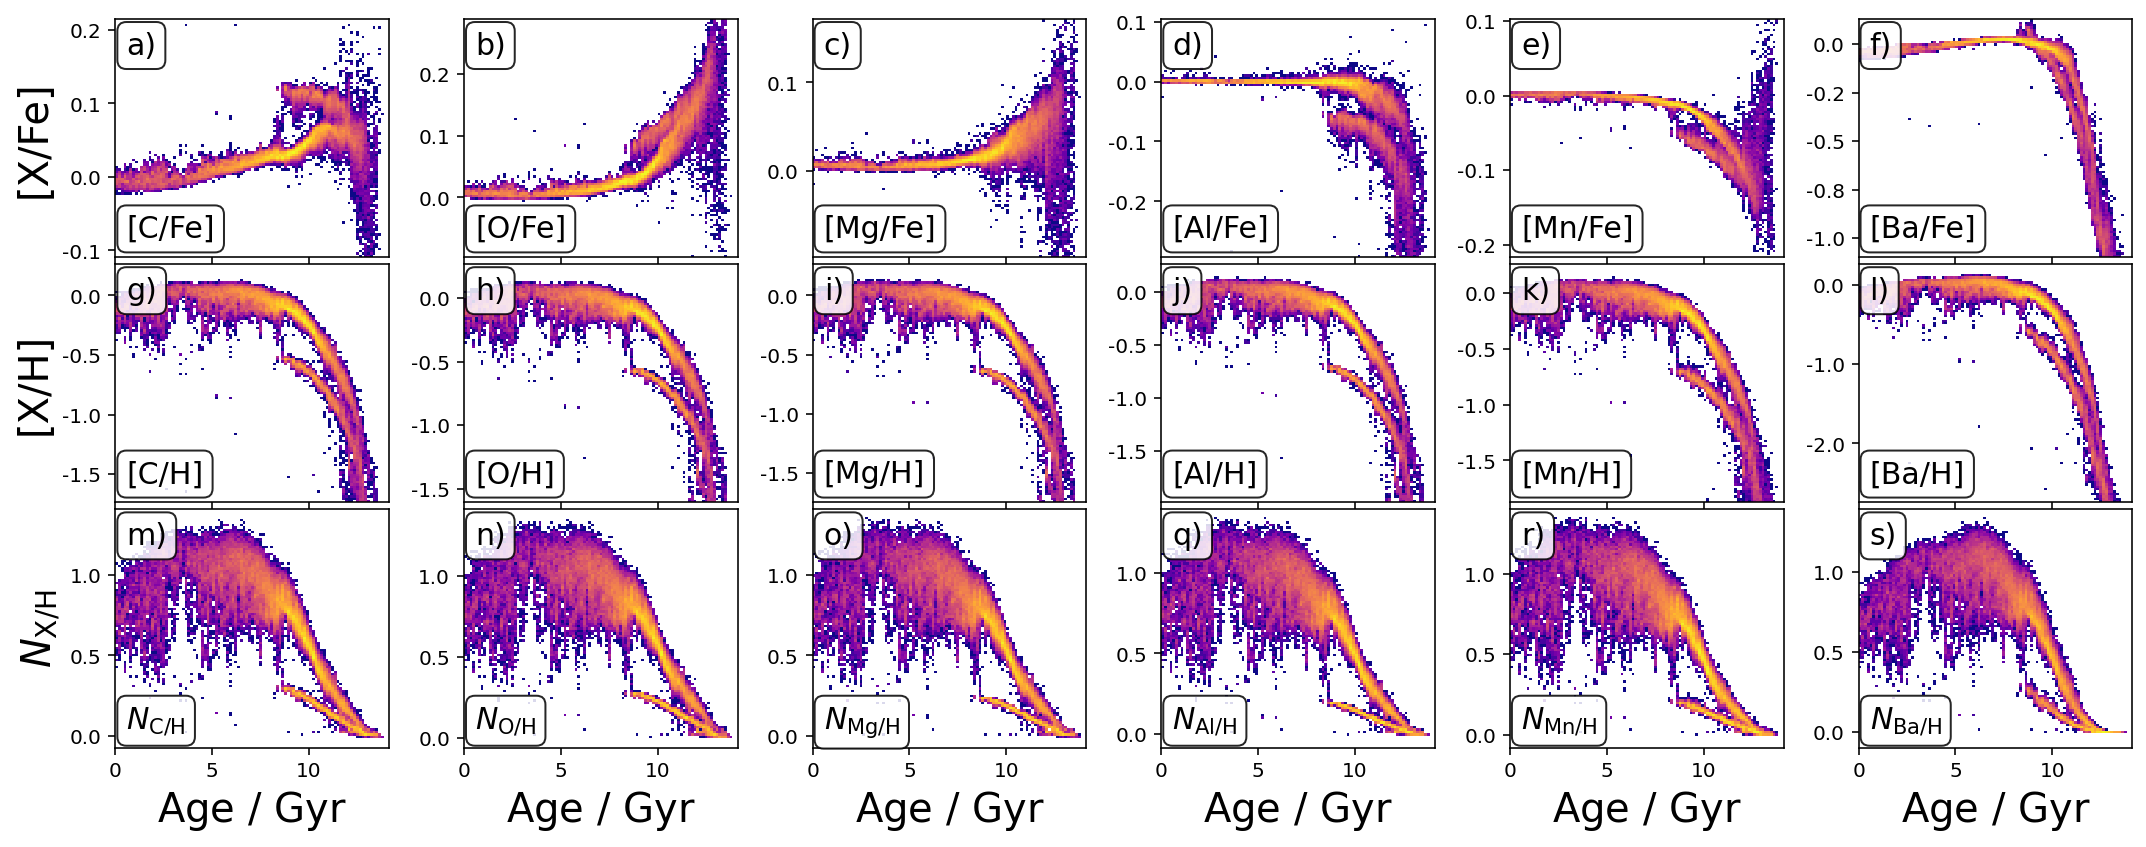

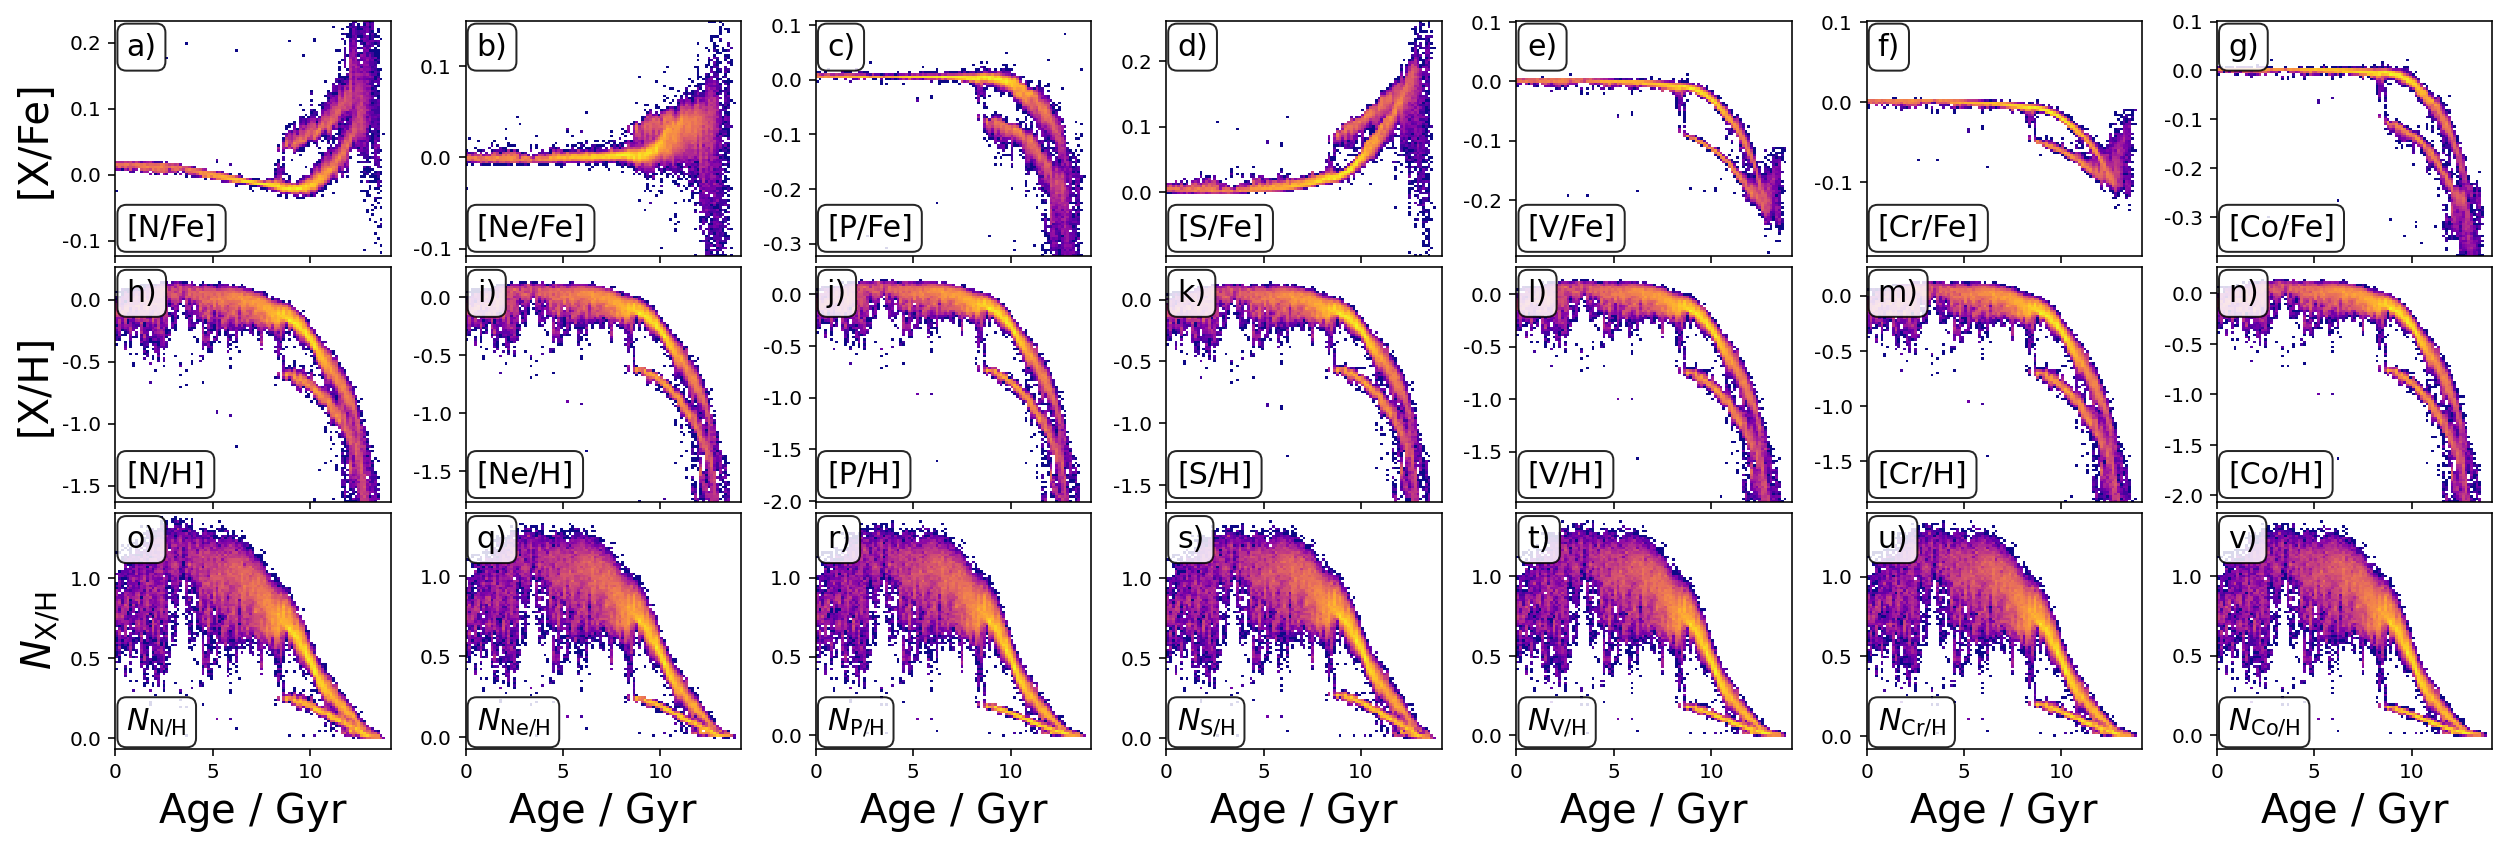

In [12]:
def plot_age_xfe_xh_nxh(share_axes=True, for_paper=True):
    
    if for_paper:
        elements = [
            'C',
            'O',
            'Mg',
            'Al',
            'Mn',
            'Ba'
            ]
    else:
        elements = [
        'N',
        'Ne',
        'P',
        'S',
        'V',
        'Cr',
        'Co',
        ]
    
    if share_axes:
        f, gs = plt.subplots(3,len(elements),figsize=(2.5*len(elements),6),sharex=True)
    else:
        f, gs = plt.subplots(3,len(elements),figsize=(2.5*len(elements),6))
    
    for element_index, element in enumerate(elements):

        age_bins = np.linspace(young_age_cutoff,14.14,100)

        # age - [X/Fe]

        ax = gs[0,element_index]
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.text(0.04,0.95,panels[element_index],fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
        if not share_axes:
            ax.set_xlabel(r'$\mathrm{Age}~/~\mathrm{Gyr}$',fontsize=20)
            ax.set_ylabel(r'['+element+'/Fe]',fontsize=20)
        else:
            ax.text(0.04,0.18,r'['+element+'/Fe]',fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
            if element_index == 0:
                ax.set_ylabel(r'[X/Fe]',fontsize=20)

        percentiles = np.percentile(sim[element+'_H'] - sim['Fe_H'],q=[2.5,97.5])    
        p = ax.hist2d(
                sim['age'],
                sim[element+'_H'] - sim['Fe_H'],
                bins = (age_bins,np.linspace(percentiles[0]-0.1,percentiles[-1]+0.1,100)),
                cmin = 1, cmap='plasma',
                norm = LogNorm()
            )

        # age - [X/Fe]

        ax = gs[1,element_index]
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.text(0.04,0.95,panels[len(elements)+element_index],fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
        if not share_axes:
            ax.set_xlabel(r'$\mathrm{Age}~/~\mathrm{Gyr}$',fontsize=20)
            ax.set_ylabel(r'['+element+'/H]',fontsize=20)
        else:
            ax.text(0.04,0.18,r'['+element+'/H]',fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
            if element_index == 0:
                ax.set_ylabel(r'[X/H]',fontsize=20)

        percentiles = np.percentile(sim[element+'_H'],q=[2.5,97.5])    
        p = ax.hist2d(
                sim['age'],
                sim[element+'_H'],
                bins = (age_bins,np.linspace(percentiles[0]-0.2,percentiles[-1]+0.2,100)),
                cmin = 1, cmap='plasma',
                norm = LogNorm()
            )
        # age - [X/Fe]

        ax = gs[2,element_index]
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.set_xlabel(r'$\mathrm{Age}~/~\mathrm{Gyr}$',fontsize=20)
        ax.text(0.04,0.95,panels[2*len(elements)+element_index],fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
        if not share_axes:
            ax.set_ylabel(r'$N_\mathrm{'+element+'/H}$',fontsize=20)
        else:
            ax.text(0.04,0.18,r'$N_\mathrm{'+element+'/H}$',fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
            if element_index == 0:
                ax.set_ylabel(r'$N_\mathrm{X/H}$',fontsize=20)
            
        percentiles = np.percentile(10**sim[element+'_H'],q=[2.5,97.5])    
        p = ax.hist2d(
                sim['age'],
                10**sim[element+'_H'],
                bins = (age_bins,np.linspace(percentiles[0]-0.1,percentiles[-1]+0.25,100)),
                cmin = 1, cmap='plasma',
                norm = LogNorm()
            )
    
    plt.tight_layout(h_pad=0)
    if for_paper:
        plt.savefig('figures/age_xfe_xh_nxh.png',dpi=200,bbox_inches='tight')
    else:
        plt.savefig('figures/age_xfe_xh_nxh_others.png',dpi=200,bbox_inches='tight')
    plt.show()
    plt.close()
    
plot_age_xfe_xh_nxh()
plot_age_xfe_xh_nxh(for_paper=False)

/Users/buder/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(
/Users/buder/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/Users/buder/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(
/Users/buder/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/Users/buder/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(
/Users/buder/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4650:

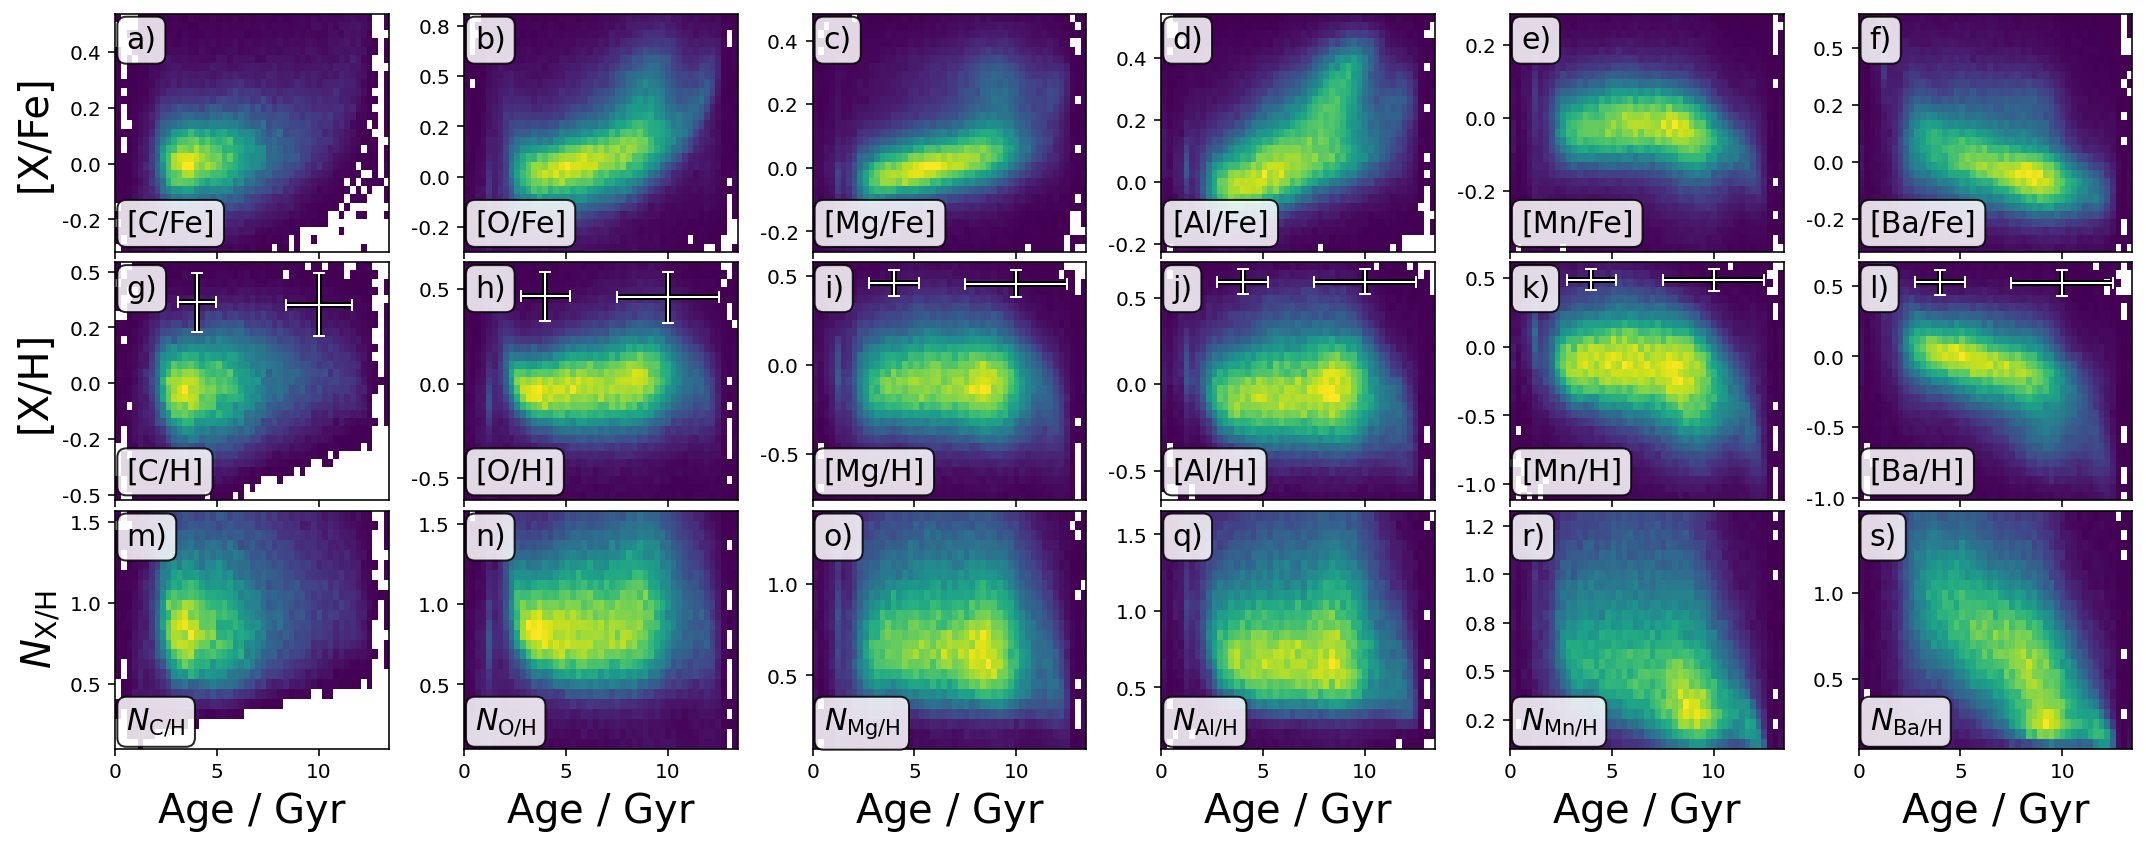

In [13]:
def plot_age_xfe_xh_nxh_galah(share_axes=True, norm=None):
    
    elements = [
        'C',
        'O',
        'Mg',
        'Al',
        'Mn',
        'Ba'
        ]
    
    if share_axes:
        f, gs = plt.subplots(3,len(elements),figsize=(2.5*len(elements),6),sharex=True)
    else:
        f, gs = plt.subplots(3,len(elements),figsize=(2.5*len(elements),6))
    
    for element_index, element in enumerate(elements):

        age_bins = np.linspace(young_age_cutoff,13.45,50)

        # We apply our usual quality checks, but here for each element individually
        observation_quality_check = (
            (obs['flag_'+element+'_fe'] == 0) &
            (obs['fe_h'] >= fe_h_poor_cutoff)
        )
        
        # age - [X/Fe]

        ax = gs[0,element_index]
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.text(0.04,0.95,panels[element_index],fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
        if not share_axes:
            ax.set_xlabel(r'$\mathrm{Age}~/~\mathrm{Gyr}$',fontsize=20)
            ax.set_ylabel(r'['+element+'/Fe]',fontsize=20)
        else:
            ax.text(0.04,0.18,r'['+element+'/Fe]',fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
            if element_index == 0:
                ax.set_ylabel(r'[X/Fe]',fontsize=20)
                
        

        percentiles = np.percentile(obs[element+'_fe'][observation_quality_check],q=[2.5,97.5])    
        p = ax.hist2d(
            obs['age_bstep'][observation_quality_check],
            obs[element+'_fe'][observation_quality_check],
            bins = (age_bins,np.linspace(percentiles[0]-0.1,percentiles[-1]+0.1,30)),
            cmin = 1, cmap='viridis',
            norm = norm
        )

        # age - [X/H]

        ax = gs[1,element_index]
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.text(0.04,0.95,panels[len(elements)+element_index],fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
        if not share_axes:
            ax.set_xlabel(r'$\mathrm{Age}~/~\mathrm{Gyr}$',fontsize=20)
            ax.set_ylabel(r'['+element+'/H]',fontsize=20)
        else:
            ax.text(0.04,0.18,r'['+element+'/H]',fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
            if element_index == 0:
                ax.set_ylabel(r'[X/H]',fontsize=20)

        percentiles = np.percentile(obs[element+'_fe'][observation_quality_check] + obs['fe_h'][observation_quality_check],q=[2.5,97.5])    
        p = ax.hist2d(
            obs['age_bstep'][observation_quality_check],
            obs[element+'_fe'][observation_quality_check] + obs['fe_h'][observation_quality_check],
            bins = (age_bins,np.linspace(percentiles[0]-0.2,percentiles[-1]+0.2,30)),
            cmin = 1, cmap='viridis',
            norm = norm
        )

        yl = ax.get_ylim()
        quality_cut2 = (obs['age_bstep'] < 7) & (obs['e_'+element+'_fe'] < 1)
        xerr = np.ma.median(obs['e_age_bstep'][quality_cut2])
        yerr = np.ma.median(obs['e_'+element+'_fe'][quality_cut2])
        error_position = [4,0.02*yl[0]+0.98*yl[-1]-1.2*yerr]
        ax.errorbar(
            error_position[0],
            error_position[1],
            xerr = xerr,
            yerr = yerr,
            c = 'k', capsize=3, lw=3
        )
        ax.errorbar(
            error_position[0],
            error_position[1],
            xerr = xerr,
            yerr = yerr,
            c = 'w', capsize=3, lw=1
        )
        
        yl = ax.get_ylim()
        quality_cut2 = (obs['age_bstep'] > 7) & (obs['e_'+element+'_fe'] < 1)
        xerr = np.ma.median(obs['e_age_bstep'][quality_cut2])
        yerr = np.ma.median(obs['e_'+element+'_fe'][quality_cut2])
        error_position = [10,0.02*yl[0]+0.98*yl[-1]-1.2*yerr]
        ax.errorbar(
            error_position[0],
            error_position[1],
            xerr = xerr,
            yerr = yerr,
            c = 'k', capsize=3, lw=3
        )
        ax.errorbar(
            error_position[0],
            error_position[1],
            xerr = xerr,
            yerr = yerr,
            c = 'w', capsize=3, lw=1
        )
        
        # age - N_XH

        ax = gs[2,element_index]
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.set_xlabel(r'$\mathrm{Age}~/~\mathrm{Gyr}$',fontsize=20)
        ax.text(0.04,0.95,panels[2*len(elements)+element_index],fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
        if not share_axes:
            ax.set_ylabel(r'$N_\mathrm{'+element+'/H}$',fontsize=20)
        else:
            ax.text(0.04,0.18,r'$N_\mathrm{'+element+'/H}$',fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
            if element_index == 0:
                ax.set_ylabel(r'$N_\mathrm{X/H}$',fontsize=20)
            
        percentiles = np.percentile(10**(obs[element+'_fe'][observation_quality_check] + obs['fe_h'][observation_quality_check]),q=[2.5,75])    
        p = ax.hist2d(
            obs['age_bstep'][observation_quality_check],
            10**(obs[element+'_fe'][observation_quality_check] + obs['fe_h'][observation_quality_check]),
            bins = (age_bins,np.linspace(0.1,percentiles[-1]+0.25,25)),
            cmin = 1, cmap='viridis',
            norm = norm
        )
    
    plt.tight_layout(h_pad=0)
    plt.savefig('figures/age_xfe_xh_nxh_galah.png',dpi=200,bbox_inches='tight')
    plt.show()
    plt.close()

plot_age_xfe_xh_nxh_galah()

## 4.3 Quantifying differences of age-[X/H] sequences

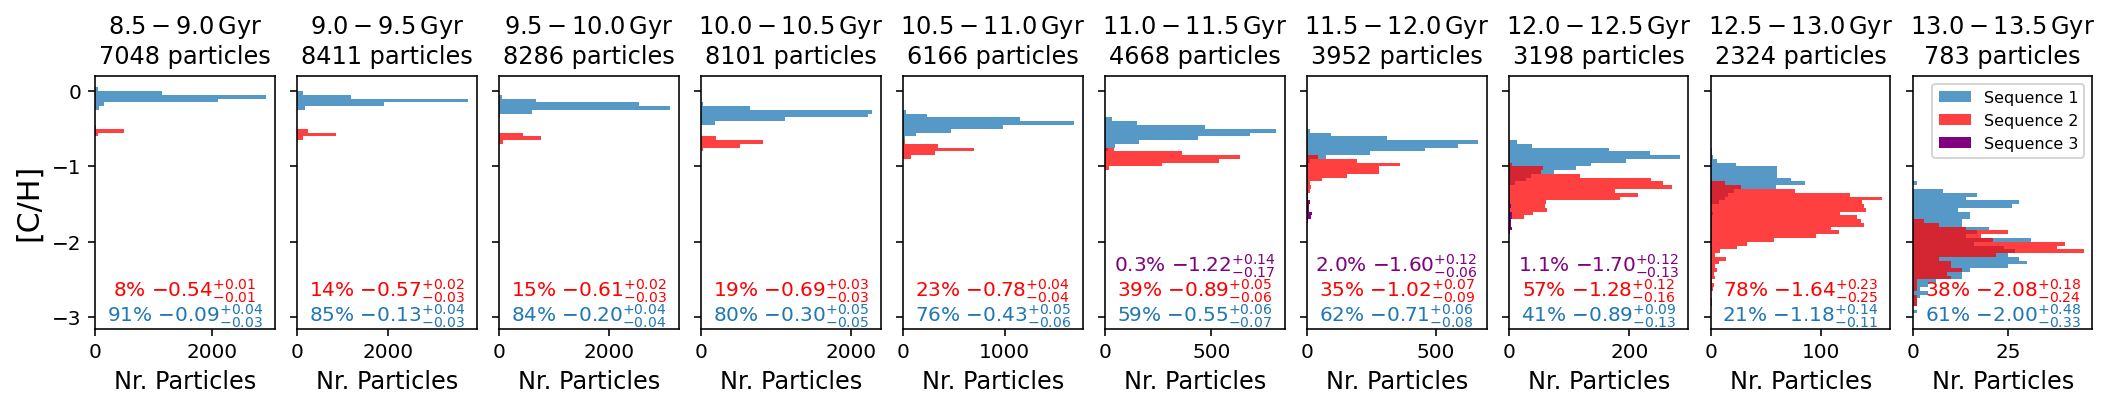

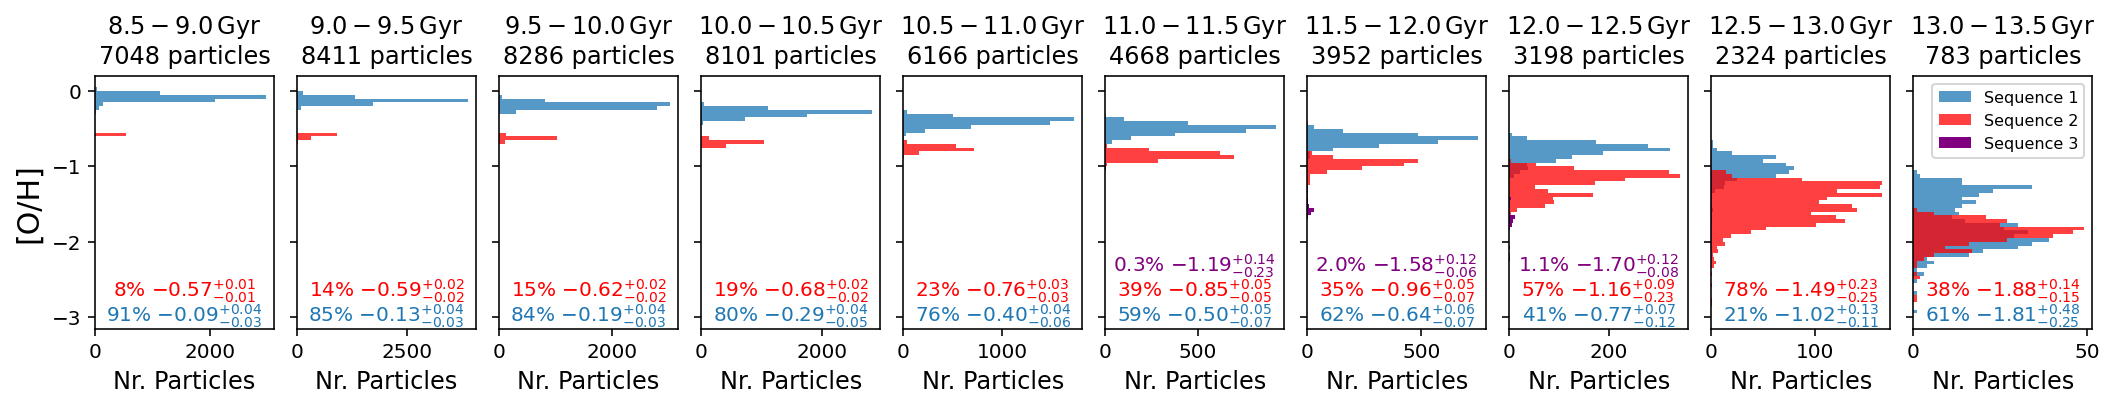

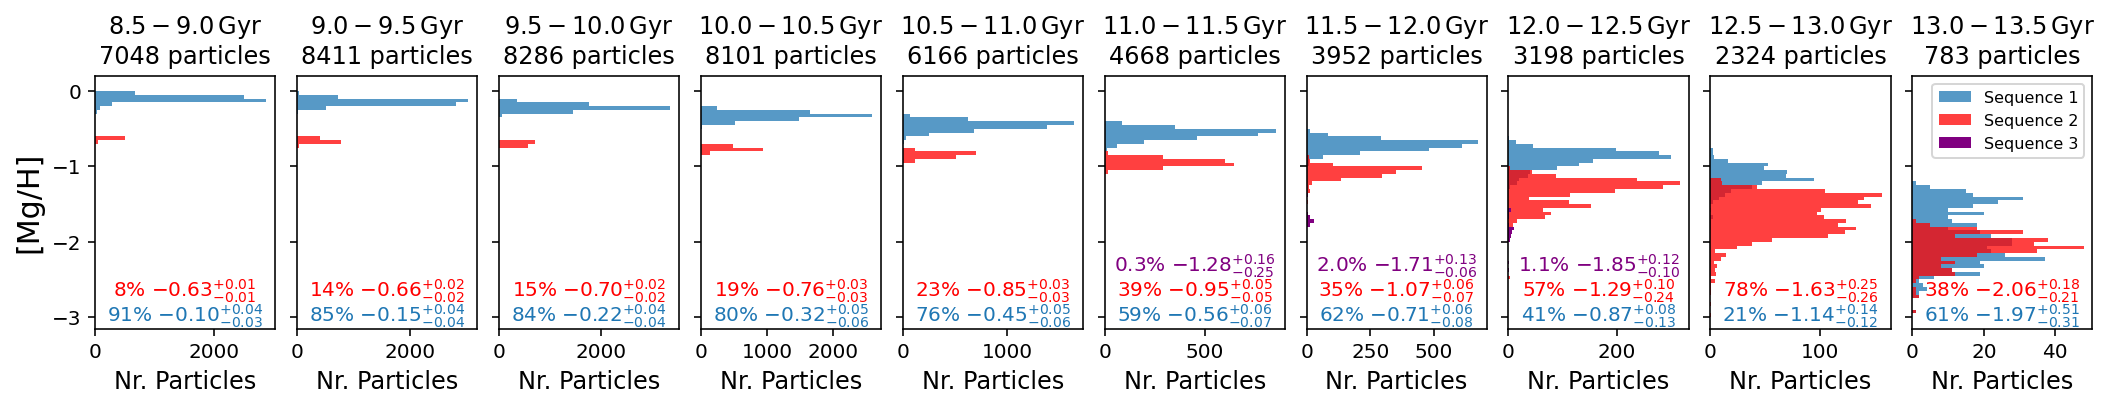

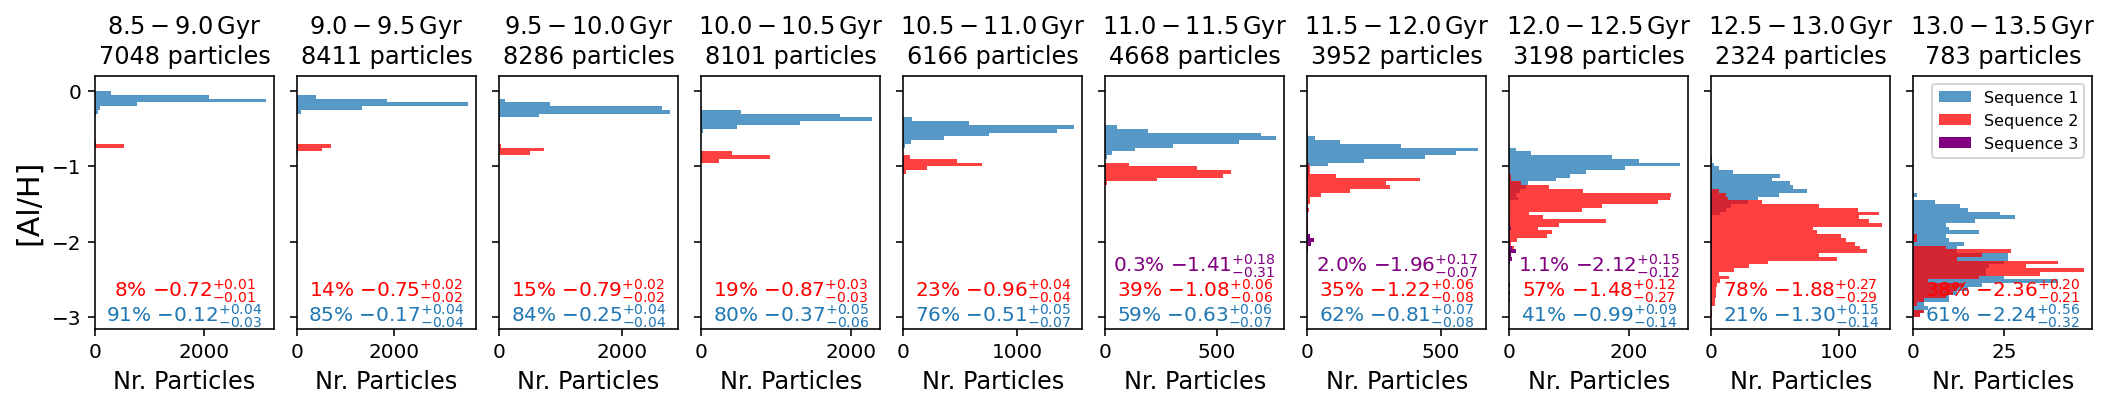

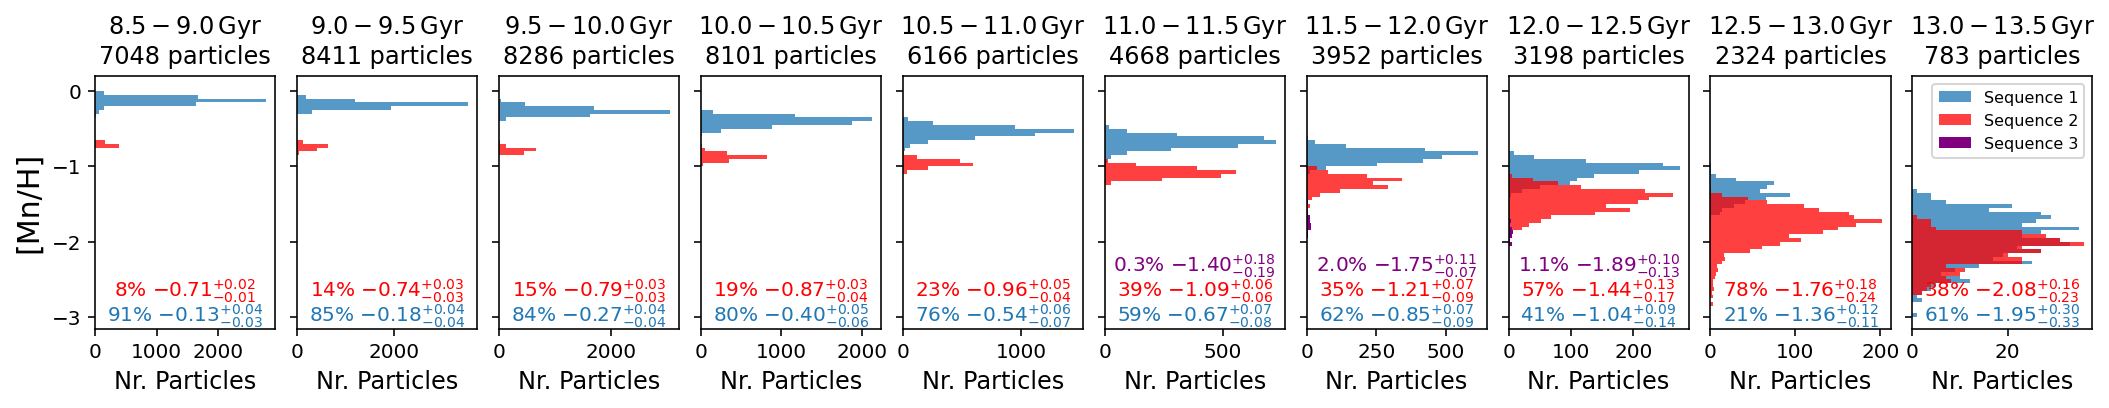

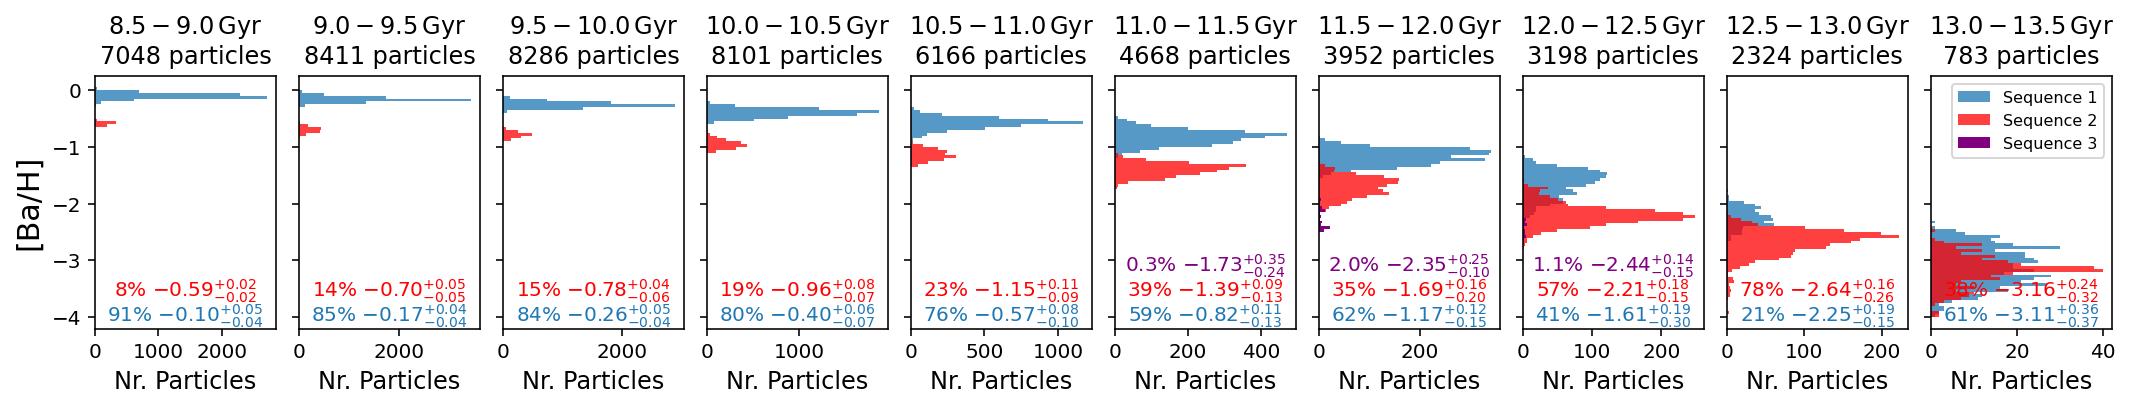

In [14]:
def plot_age_xh_sequences(element,sharex=False):
    
    age_bin_size = 0.5
    age_bins = np.arange(8.75,13.75,age_bin_size)

    f, gs = plt.subplots(1,len(age_bins),figsize=(15,3),sharex=sharex,sharey=True)

    for bin_index, age_bin in enumerate(age_bins):
        
        in_age_bin = (sim['age'] >= age_bin - 0.5*age_bin_size) & (sim['age'] < age_bin + 0.5*age_bin_size)

        in_sequence_and_bin = dict()
        in_sequence_and_bin['1'] = (age_feh_sequences['1']) & (sim['age'] >= age_bin - 0.5*age_bin_size) & (sim['age'] < age_bin + 0.5*age_bin_size)
        in_sequence_and_bin['2'] = (age_feh_sequences['2']) & (sim['age'] >= age_bin - 0.5*age_bin_size) & (sim['age'] < age_bin + 0.5*age_bin_size)
        in_sequence_and_bin['3'] = (age_feh_sequences['3']) & (sim['age'] >= age_bin - 0.5*age_bin_size) & (sim['age'] < age_bin + 0.5*age_bin_size)

        # min-max bins
        bins = np.linspace(np.min(sim[element+'_H'][in_age_bin]),np.max(sim[element+'_H'][in_age_bin]),100)
        
        # smarter selection
        bins = np.arange(-3.0,0.1,0.05)
        if element == 'Ba':
            bins = np.arange(-4.0,0.1,0.05)
        
        ax = gs[bin_index]
        ax.hist(
            sim[element+'_H'][in_sequence_and_bin['1']],
            label = 'Sequence 1',
            bins = bins,
            color = colors[0],alpha=0.75,
            orientation="horizontal"
        )
        ax.hist(
            sim[element+'_H'][in_sequence_and_bin['2']],
            label = 'Sequence 2',
            bins = bins,
            color = colors[1],alpha=0.75,
            orientation="horizontal"
        )
        ax.hist(
            sim[element+'_H'][in_sequence_and_bin['3']],
            label = 'Sequence 3',
            bins = bins,
            color = colors[2],
            orientation="horizontal"
        )
        
        if len(sim[element+'_H'][in_sequence_and_bin['1']]) > 10:

            perc_seq1 = np.percentile(sim[element+'_H'][in_sequence_and_bin['1']],q=[16,50,84])
            
            ax.text(
                0.5,0.05,
                str(int(100*len(sim[element+'_H'][in_sequence_and_bin['1']])/len(sim[element+'_H'][in_age_bin])))+r'% $'+"{:.2f}".format(perc_seq1[1])+r'_{-'+"{:.2f}".format(perc_seq1[1]-perc_seq1[0])+r'}^{+'+"{:.2f}".format(perc_seq1[2]-perc_seq1[1])+r'}$',
                va = 'center',ha='center',
                transform=ax.transAxes,
                color = colors[0]
            )
        if len(sim[element+'_H'][in_sequence_and_bin['2']]) > 10:

            perc_seq2 = np.percentile(sim[element+'_H'][in_sequence_and_bin['2']],q=[16,50,84])

            ax.text(
                0.5,0.15,
                str(int(100*len(sim[element+'_H'][in_sequence_and_bin['2']])/len(sim[element+'_H'][in_age_bin])))+r'% $'+"{:.2f}".format(perc_seq2[1])+r'_{-'+"{:.2f}".format(perc_seq2[1]-perc_seq2[0])+r'}^{+'+"{:.2f}".format(perc_seq2[2]-perc_seq2[1])+r'}$',
                va = 'center',ha='center',
                transform=ax.transAxes,
                color = colors[1]
            )

        if len(sim[element+'_H'][in_sequence_and_bin['3']]) > 10:
            
            perc_seq3 = np.percentile(sim[element+'_H'][in_sequence_and_bin['3']],q=[16,50,84])

            ax.text(
                0.5,0.25,
                "{:.1f}".format(100*len(sim[element+'_H'][in_sequence_and_bin['3']])/len(sim[element+'_H'][in_age_bin]))+r'% $'+"{:.2f}".format(perc_seq3[1])+r'_{-'+"{:.2f}".format(perc_seq3[1]-perc_seq3[0])+r'}^{+'+"{:.2f}".format(perc_seq3[2]-perc_seq3[1])+r'}$',
                va = 'center',ha='center',
                transform=ax.transAxes,
                color = colors[2]
            )
        
        if bin_index == 0:
            ax.set_ylabel('['+element+'/H]')
        if bin_index == len(age_bins)-1:
            ax.legend(fontsize=8)
        ax.set_xlabel('Nr. Particles',fontsize=12)
        ax.set_title(r'$'+"{:.1f}".format(age_bin - 0.5*age_bin_size)+'-'+"{:.1f}".format(age_bin + 0.5*age_bin_size)+'\,\mathrm{Gyr}$\n'+str(len(sim['Fe_H'][in_age_bin]))+' particles',fontsize=12)
        
    plt.tight_layout(w_pad=0)
    plt.savefig('figures/histograms_xh_in_age_bins_'+element+'.pdf',dpi=200,bbox_inches='tight')
    plt.show()
    plt.close()

for element in [
    'C',
    'O',
    'Mg',
    'Al',
    'Mn',
    'Ba'
]:
    plot_age_xh_sequences(element, sharex=False)


In [15]:
def estimate_separation_significance(elements,sharex=False):
    
    rmax_table = Table()
    rmax_table['Element'] = elements
    rmax_table['r_12'] = np.zeros(len(elements))
    
    age_bin_size = 0.5
    age_bins = np.arange(8.75,13.75,age_bin_size)

    nr_columns = 'cc'
    header = 'Element & Quantity '
    for bin_index, age_bin in enumerate(age_bins):
        header = header+' & '+str(age_bin - 0.5*age_bin_size)+'-'+str(age_bin + 0.5*age_bin_size)
        nr_columns = nr_columns+'c'
    header = header+r' \\'
    
    tabular_text = [
        [r'\begin{tabular}{'+nr_columns+'}'],
        [r'\hline\hline']
    ]
    tabular_text.append([header])
    tabular_text.append([r'\hline'])

    separation_significance = dict()

    for element_index, element in enumerate(elements):
        
        row_text = dict()
        row_text['1'] = '['+element+'/H] & $\mu_1 \pm \sigma_1$ '
        row_text['2'] = ' & $\mu_2 \pm \sigma_2$ '
        row_text['3'] = ' & $\mu_3 \pm \sigma_3$ '
        row_r = '  & $r_{12}$ '
        
        for bin_index, age_bin in enumerate(age_bins):
            
                    
            separation_significance[element] = dict()

            in_age_bin = (sim['age'] >= age_bin - 0.5*age_bin_size) & (sim['age'] < age_bin + 0.5*age_bin_size)
            in_sequence_and_bin = dict()
            in_sequence_and_bin['1'] = (age_feh_sequences['1']) & (sim['age'] >= age_bin - 0.5*age_bin_size) & (sim['age'] < age_bin + 0.5*age_bin_size)
            in_sequence_and_bin['2'] = (age_feh_sequences['2']) & (sim['age'] >= age_bin - 0.5*age_bin_size) & (sim['age'] < age_bin + 0.5*age_bin_size)
            in_sequence_and_bin['3'] = (age_feh_sequences['3']) & (sim['age'] >= age_bin - 0.5*age_bin_size) & (sim['age'] < age_bin + 0.5*age_bin_size)
            
            sequences_mu = dict()
            sequences_sigma = dict()

            for seq in ['1','2','3']:
                
                if len(sim[element+'_H'][in_sequence_and_bin[seq]]) > 10:
                    sequences_mu[seq] = np.mean(sim[element+'_H'][in_sequence_and_bin[seq]])
                    sequences_sigma[seq] = np.std(sim[element+'_H'][in_sequence_and_bin[seq]])                
                    row_text[seq] = row_text[seq]+r' & $'+"{:.2f}".format(sequences_mu[seq])+' \pm '+"{:.2f}".format(sequences_sigma[seq])+'$ '
                else:
                    row_text[seq] = row_text[seq]+' & - '
                    
            r_12 = np.round(np.abs(sequences_mu['1']-sequences_mu['2']) / np.sqrt(sequences_sigma['1']**2+sequences_sigma['2']**2),1)

            if r_12 > rmax_table['r_12'][element_index]:
                rmax_table['r_12'][element_index] = r_12
            
            row_r = row_r + r' & '+str(r_12)
                    
        if element not in ['Ne','P']:
            tabular_text.append([row_text['1']+r' \\'])
            tabular_text.append([row_text['2']+r' \\'])
            tabular_text.append([row_text['3']+r' \\'])
            tabular_text.append([row_r+r' \\'])
            tabular_text.append([r'\hline'])

    tabular_text.append([r'\hline'])
    tabular_text.append([r'\end{tabular}'])
        
    np.savetxt('tables/tabular_separation_r12.tex',tabular_text,fmt='%s')

    return(rmax_table)
    
elements = [
    'C',
    'N',
    'O',
    'Ne',
    'Mg',
    'Al',
    'Si',
    'P',
    'S',
    'V',
    'Cr',
    'Mn',
    'Fe',
    'Co',
    'Ba'
]
            
rmax_table = estimate_separation_significance(elements, sharex=False)
rmax_table.sort('r_12',reverse=True)

r12_sorted = ''

for row_index, row in enumerate(rmax_table):
    if row_index < len(rmax_table)-1:
        r12_sorted = r12_sorted+row['Element']+' ('+str(row['r_12'])+'), '
    else:
        r12_sorted = r12_sorted+'and '+row['Element']+' ('+str(row['r_12'])+')%'
np.savetxt('tex_text/r12_sorted.tex',[r12_sorted],fmt='%s')
print(r12_sorted)

P (12.7), Al (12.7), Co (12.6), V (12.2), Mg (12.0), Cr (11.8), Mn (11.5), Si (11.5), Fe (11.4), Ne (11.4), O (11.4), S (11.1), C (10.5), N (10.3), and Ba (9.1)%


## 4.2.3 A more realistic picture: The influence of observational noise on age-[X/H] sequence

In [16]:
def estimate_separation_significance_for_different_sigma_obs(elements,sigmas,sharex=False):
    
    age_bin_size = 0.5
    age_bins = np.arange(8.75,13.75,age_bin_size)

    nr_columns = 'cc'
    header = r'Element & $\sigma_\mathrm{obs}$ '
    for bin_index, age_bin in enumerate(age_bins):
        header = header+' & '+str(age_bin - 0.5*age_bin_size)+'-'+str(age_bin + 0.5*age_bin_size)
        nr_columns = nr_columns+'c'
    header = header+r' \\'
    
    tabular_text = [
        [r'\begin{tabular}{'+nr_columns+'}'],
        [r'\hline\hline']
    ]
    tabular_text.append([header])
    tabular_text.append([r'\hline'])

    separation_significance = dict()

    for element_index, element in enumerate(elements):
                
        separation_significance[element] = dict()

        for sigma_index, sigma in enumerate(sigmas):
            
            separation_significance[element]["{:.2f}".format(sigma)] = dict()
            
            if sigma == 0.05:
                row_r = '['+element+'/H] & '+"{:.2f}".format(sigma)
            elif sigma == 0.10:
                row_r = r'$\sigma_\mathrm{GALAH}$ & '+"{:.2f}".format(sigma)
            elif sigma == 0.15:
                if element != 'Fe':
                    unflagged_galah_e_x_fe = (obs['flag_'+element+'_fe'] == 0)
                    row_r = "{:.2f}".format(np.median(obs['e_'+element+'_fe'][unflagged_galah_e_x_fe]))+r' & '+"{:.2f}".format(sigma)
                else:
                    unflagged_galah_e_x_fe = obs['flag_fe_h'] == 0
                    row_r = "{:.2f}".format(np.median(obs['e_fe_h'][unflagged_galah_e_x_fe]))+r' & '+"{:.2f}".format(sigma)
                    
            for bin_index, age_bin in enumerate(age_bins):

                in_age_bin = (sim['age'] >= age_bin - 0.5*age_bin_size) & (sim['age'] < age_bin + 0.5*age_bin_size)
                in_sequence_and_bin = dict()
                in_sequence_and_bin['1'] = (age_feh_sequences['1']) & (sim['age'] >= age_bin - 0.5*age_bin_size) & (sim['age'] < age_bin + 0.5*age_bin_size)
                in_sequence_and_bin['2'] = (age_feh_sequences['2']) & (sim['age'] >= age_bin - 0.5*age_bin_size) & (sim['age'] < age_bin + 0.5*age_bin_size)

                sequences_mu = dict()
                sequences_sigma = dict()

                for seq in ['1','2']:

                    sequences_mu[seq] = np.mean(sim[element+'_H'][in_sequence_and_bin[seq]])
                    sequences_sigma[seq] = np.std(sim[element+'_H'][in_sequence_and_bin[seq]])                
                    
                r_12 = np.round(
                    np.abs(sequences_mu['1']-sequences_mu['2']) / 
                    np.sqrt(sequences_sigma['1']**2+sequences_sigma['2']**2+2*sigma**2),1)

                separation_significance[element]["{:.2f}".format(sigma)][age_bin] = r_12

                if sigma in [0.05,0.10,0.15]:
                    row_r = row_r + r' & '+str(r_12)

            if sigma in [0.05,0.10,0.15]:
                tabular_text.append([row_r+r' \\'])
        tabular_text.append([r'\hline'])

    tabular_text.append([r'\hline'])
    tabular_text.append([r'\end{tabular}'])

    np.savetxt('tables/tabular_separation_r12_noise.tex',tabular_text,fmt='%s')

    return(separation_significance)
    
elements = [
    'C',
    'O',
    'Mg',
    'Al',
    'Si',
    'V',
    'Cr',
    'Mn',
    'Fe',
    'Co',
    'Ba'
]

separation_significance = estimate_separation_significance_for_different_sigma_obs(elements, sigmas = [0.00,0.02,0.05,0.10,0.15,0.20,0.30,0.40],sharex=False)

/Users/buder/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


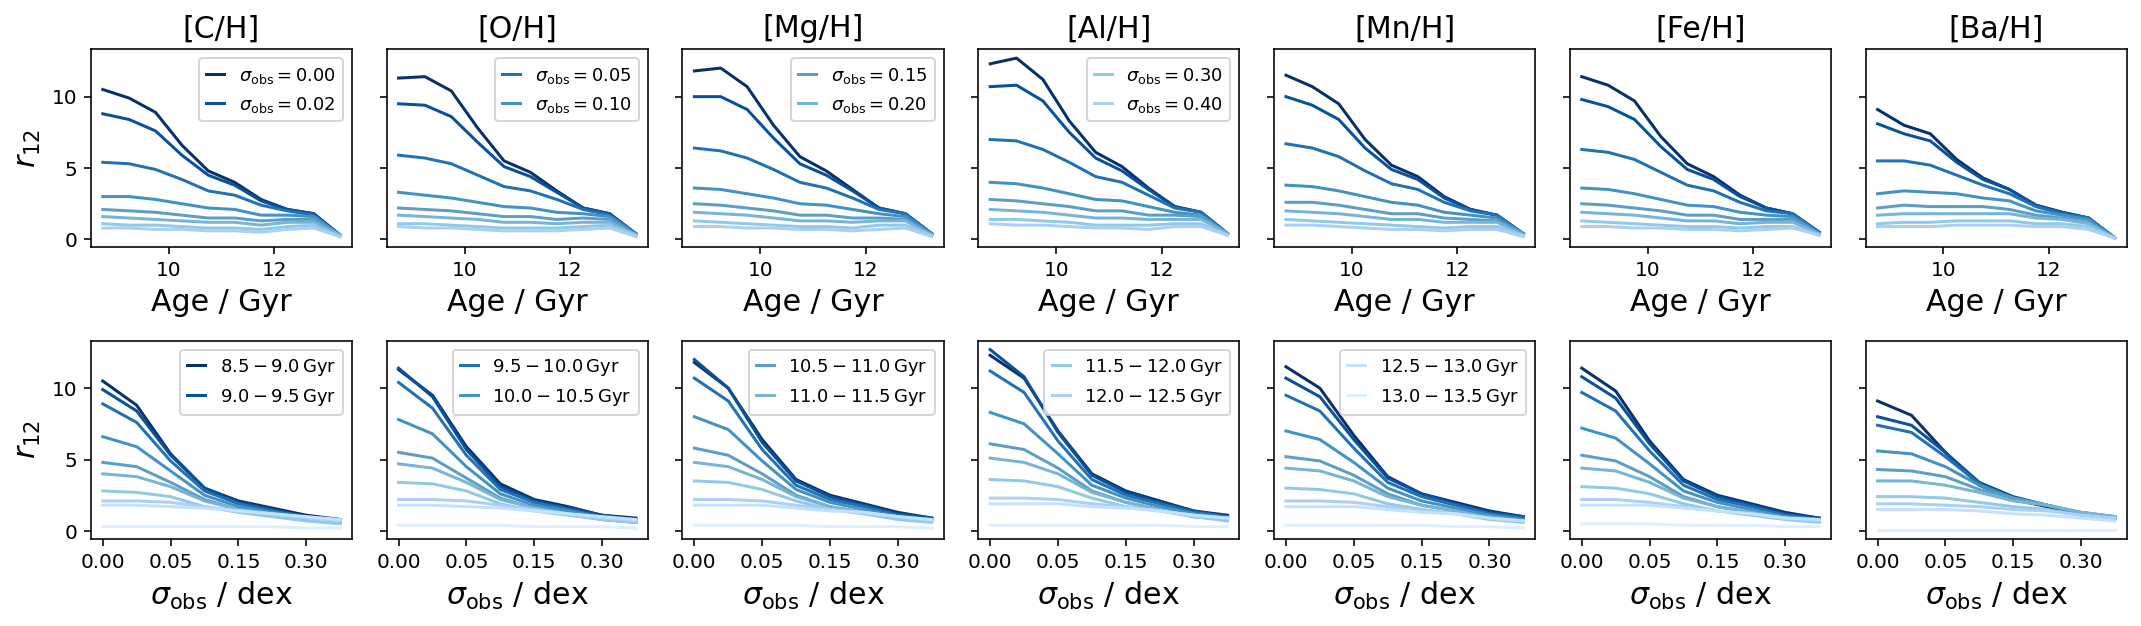

In [17]:
blues = ['#08306b', '#08519c', '#2171b5', '#4292c6', '#5d9ec6', '#77b4d6', '#91cae6', '#abcff5', '#c4e1ff', '#ddeeff']

f, gs = plt.subplots(2,7,figsize=(15,4.5), sharey=True)

for element_index, element in enumerate(['C','O','Mg','Al','Mn','Fe','Ba']):
    
    ax = gs[0,element_index]

    for sigma_index, sigma_obs in enumerate(separation_significance[element].keys()):

        use_label = False
        if (sigma_index < 2) & (element == 'C'):
            label = r'$\sigma_\mathrm{obs} = '+sigma_obs+'$'
            use_label = True
        elif (sigma_index >= 2) & (sigma_index < 4) & (element == 'O'):
            label = r'$\sigma_\mathrm{obs} = '+sigma_obs+'$'
            use_label = True
        elif (sigma_index >= 4) & (sigma_index < 6) & (element == 'Mg'):
            label = r'$\sigma_\mathrm{obs} = '+sigma_obs+'$'
            use_label = True
        elif (sigma_index >= 6) & (sigma_index < 8) & (element == 'Al'):
            label = r'$\sigma_\mathrm{obs} = '+sigma_obs+'$'
            use_label = True
        else:
            label = '_nolegend_'

        ages = separation_significance[element][sigma_obs].keys()
        r = [separation_significance[element][sigma_obs][age] for age in separation_significance[element][sigma_obs].keys()]
        ax.plot(
            ages,
            r,
            c = blues[sigma_index],
            label = label
        )
        if use_label:
            ax.legend(loc='upper right',fontsize=9, handlelength=1)
    ax.set_xlabel('Age / Gyr',fontsize=15)
    if element_index == 0:
        ax.set_ylabel(r'$r_{12}$',fontsize=15)
    ax.set_title(r'['+element+'/H]',fontsize=15)

for element_index, element in enumerate(['C','O','Mg','Al','Mn','Fe','Ba']):
    
    ax = gs[1,element_index]
        
    sigmas = separation_significance[element].keys()
    
    for age_index, age in enumerate(separation_significance[element]['0.00'].keys()):
        r = []
        for sigma_obs in sigmas:
            r.append(separation_significance[element][sigma_obs][age])
            
        use_label = False
        if (age_index < 2) & (element == 'C'):
            label = r'$'+str(age-0.25)+'-'+str(age+0.25)+r'\,\mathrm{Gyr}$'
            use_label = True
        elif (age_index >= 2) & (age_index < 4) & (element == 'O'):
            label = r'$'+str(age-0.25)+'-'+str(age+0.25)+r'\,\mathrm{Gyr}$'
            use_label = True
        elif (age_index >= 4) & (age_index < 6) & (element == 'Mg'):
            label = r'$'+str(age-0.25)+'-'+str(age+0.25)+r'\,\mathrm{Gyr}$'
            use_label = True
        elif (age_index >= 6) & (age_index < 8) & (element == 'Al'):
            label = r'$'+str(age-0.25)+'-'+str(age+0.25)+r'\,\mathrm{Gyr}$'
            use_label = True
        elif (age_index >= 8) & (age_index < 10) & (element == 'Mn'):
            label = r'$'+str(age-0.25)+'-'+str(age+0.25)+r'\,\mathrm{Gyr}$'
            use_label = True
        else:
            label = '_nolegend_'
        ax.plot(
            sigmas,
            r,
            c = blues[age_index],
            label = label
        )
        if use_label:
            ax.legend(fontsize=9, handlelength=1)
    ax.set_xlabel(r'$\sigma_\mathrm{obs}~/~\mathrm{dex}$',fontsize=15)
    if element_index == 0:
        ax.set_ylabel(r'$r_{12}$',fontsize=15)
    ax.xaxis.set_major_locator(MaxNLocator(4))

plt.tight_layout()
plt.savefig('figures/r12_for_sigmaobs.pdf',bbox_inches='tight',dpi=200)
plt.show()
plt.close()

/Users/buder/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/buder/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


0.2692520454351771
0.07503393965429285
0.2667924095338351
0.07391399143742944


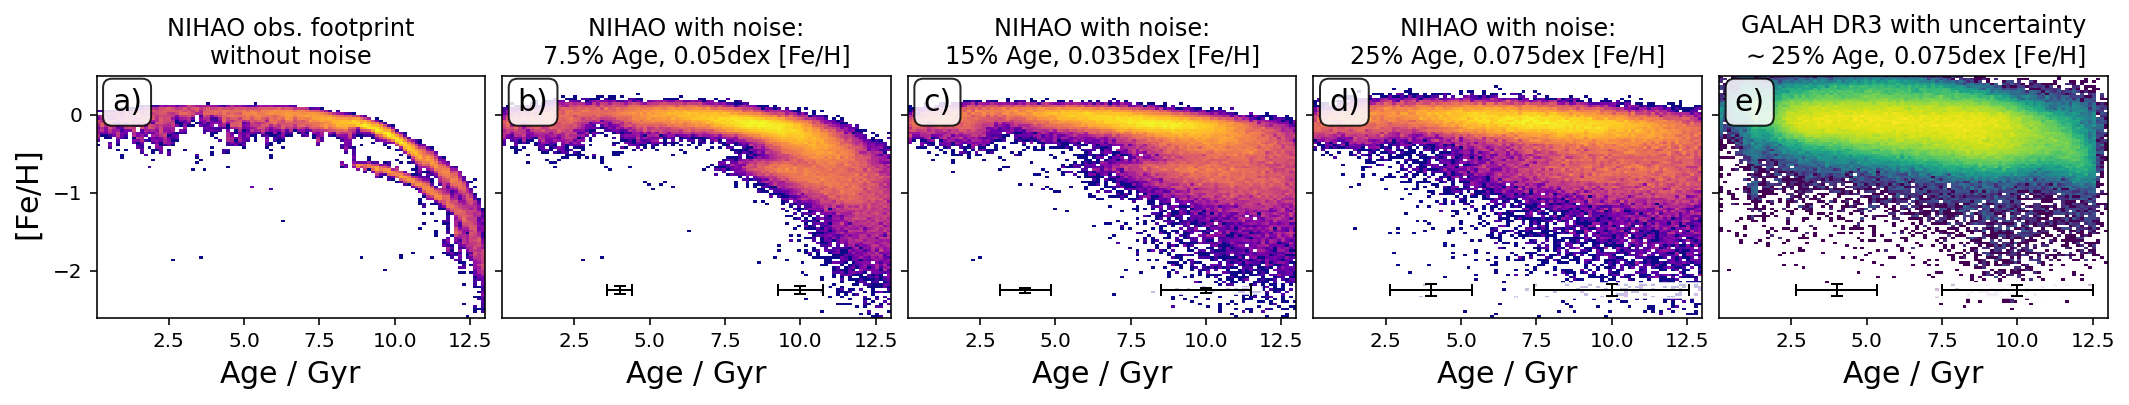

In [18]:
# Adding noise to both ages and abundances

np.random.seed(856)

sim['age_25perc_error'] = (sim['age'] * np.random.normal(loc=1.0, scale=0.25, size=len(sim['age']))).clip(min=0.0,max=14.14018534)
sim['age_15perc_error'] = (sim['age'] * np.random.normal(loc=1.0, scale=0.15, size=len(sim['age']))).clip(min=0.0,max=14.14018534)
sim['age_7.5perc_error'] = (sim['age'] * np.random.normal(loc=1.0, scale=0.075, size=len(sim['age']))).clip(min=0.0,max=14.14018534)

sim['Fe_H_0p035dex_error'] = np.random.normal(loc=sim['Fe_H'], scale=0.035)
sim['Fe_H_0p075dex_error'] = np.random.normal(loc=sim['Fe_H'], scale=0.075)
sim['Fe_H_0p05dex_error']  = np.random.normal(loc=sim['Fe_H'], scale=0.05)
sim['Fe_H_0p15dex_error']  = np.random.normal(loc=sim['Fe_H'], scale=0.15)

f, gs = plt.subplots(1,5,figsize=(15,3),sharex=True, sharey=True)

panels = ['a)','b)','c)','d)','e)']

bins = (np.linspace(0.1,13,100),np.linspace(fe_h_poor_cutoff-0.1,0.5,100))

ax = gs[0]
ax.set_title('NIHAO obs. footprint\nwithout noise')
ax.text(0.04,0.95,panels[0],transform=ax.transAxes,fontsize=15,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
ax.hist2d(
    sim['age'],
    sim['Fe_H'],
    bins = bins, norm=LogNorm(), cmap='plasma'
);
ax.set_xlabel(r'$\mathrm{Age}~/~\mathrm{Gyr}$')
ax.set_ylabel(r'$\mathrm{[Fe/H]}$')

ax = gs[1]
ax.set_title('NIHAO with noise:\n7.5% Age, 0.05dex [Fe/H]')
ax.text(0.04,0.95,panels[1],transform=ax.transAxes,fontsize=15,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
ax.hist2d(
    sim['age_7.5perc_error'],
    sim['Fe_H_0p05dex_error'],
    bins = bins, norm=LogNorm(), cmap='plasma'
);
ax.set_xlabel(r'$\mathrm{Age}~/~\mathrm{Gyr}$')

ax = gs[2]
ax.set_title('NIHAO with noise:\n15% Age, 0.035dex [Fe/H]')
ax.text(0.04,0.95,panels[2],transform=ax.transAxes,fontsize=15,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
ax.hist2d(
    sim['age_15perc_error'],
    sim['Fe_H_0p035dex_error'],
    bins = bins, norm=LogNorm(), cmap='plasma'
);
ax.set_xlabel(r'$\mathrm{Age}~/~\mathrm{Gyr}$')

ax = gs[3]
ax.set_title('NIHAO with noise:\n25% Age, 0.075dex [Fe/H]')
ax.text(0.04,0.95,panels[3],transform=ax.transAxes,fontsize=15,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
ax.hist2d(
    sim['age_25perc_error'],
    sim['Fe_H_0p075dex_error'],
    bins = bins, norm=LogNorm(), cmap='plasma'
);
ax.set_xlabel(r'$\mathrm{Age}~/~\mathrm{Gyr}$')

age_perc = ['7.5','15','25']
feh_perc = ['0.05','0.035','0.075']

for index in [1,2,3]:

    for region_index, region in enumerate([4,10.]):
        if region == 4:
            area = sim['age_'+age_perc[index-1]+'perc_error'] < 7.5
        else:
            area = sim['age_'+age_perc[index-1]+'perc_error'] > 7.5

        x = region-1.25*float(age_perc[index-1])/100*np.median(sim['age_'+age_perc[index-1]+'perc_error'][area])
        y = -2.25-1.25*float(feh_perc[index-1])
        xerr = 2.5*float(age_perc[index-1])/100*np.median(sim['age_'+age_perc[index-1]+'perc_error'][area])
        yerr = 2.5*float(feh_perc[index-1])
        
        ax = gs[index]

        rectangle = Rectangle((x,y),xerr,yerr,color = 'w',alpha=0.75)
        ax.add_patch(rectangle)
        ax.errorbar(
            [region],
            [-2.25],
            xerr = np.median(float(age_perc[index-1])/100*sim['age_'+age_perc[index-1]+'perc_error'][area]),
            yerr = np.median(float(feh_perc[index-1])),
            c = 'k', capsize=3, lw=1
        )


ax = gs[4]
ax.set_title('GALAH DR3 with uncertainty\n$\sim 25\%$ Age, 0.075dex [Fe/H]')
ax.text(0.04,0.95,panels[4],transform=ax.transAxes,fontsize=15,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
ax.hist2d(
    obs['age_bstep'],
    obs['fe_h'],
    bins = bins, norm=LogNorm()
);
ax.set_xlabel(r'$\mathrm{Age}~/~\mathrm{Gyr}$')

for region_index, region in enumerate([4,10]):
    if region == 4:
        area = obs['age_bstep'] < 7.5
    else:
        area = obs['age_bstep'] > 7.5

    x = 10-1.25*np.median(obs['e_age_bstep'][area])
    y = -2.25-1.25*np.median(obs['e_fe_h'][area])
    xerr = 2.5*np.median(obs['e_age_bstep'][area])
    
    print(np.median(obs['e_age_bstep'][area]/obs['age_bstep'][area]))
    print(np.median(obs['e_fe_h'][area]))
    yerr = 2.5*np.median(obs['e_fe_h'][area])

    rectangle = Rectangle((x,y),xerr,yerr,color = 'w',alpha=0.75)
    ax.add_patch(rectangle)
    ax.errorbar(
        [region],
        [-2.25],
        xerr = np.median(obs['e_age_bstep'][area]),
        yerr = np.median(obs['e_fe_h'][area]),
        c = 'k', capsize=3, lw=1
    )

plt.tight_layout(w_pad=0.5)
plt.savefig('figures/nihao_with_scatter.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()

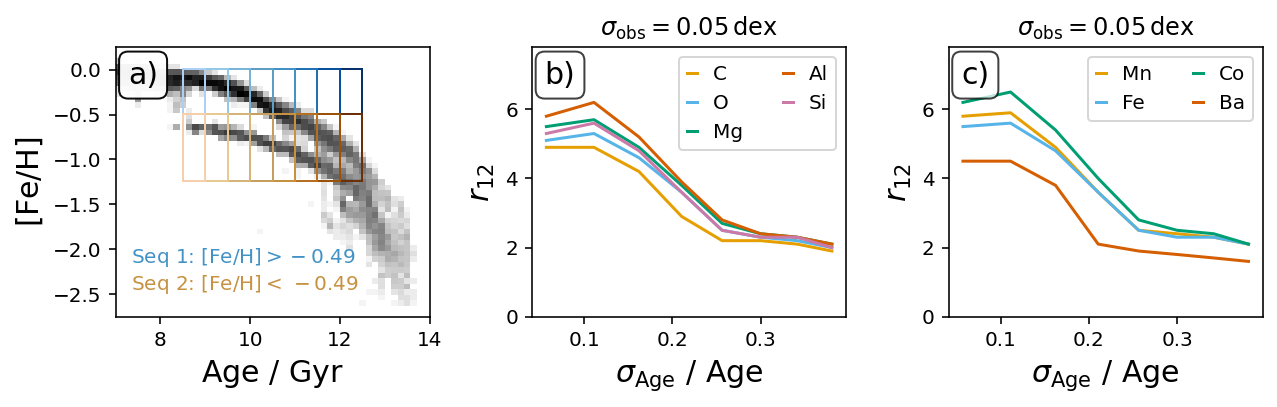

In [80]:
blues = ['#08306b', '#08519c', '#2171b5', '#4292c6', '#5d9ec6', '#77b4d6', '#91cae6', '#abcff5', '#c4e1ff', '#ddeeff']
reds = ['#6b3008', '#9c5108', '#b57121', '#c69242', '#c69e5d', '#d6b477', '#e6ca91', '#f5cfab', '#ffe1c4', '#ffeedd']

lower_age = 8.5
upper_ages = lower_age + np.arange(0.5, 13.0-lower_age, 0.5)

def get_r12_for_different_age_bins(element, lower_age, upper_ages, sigma_obs = 0.00, debug=True):

    reference_selection = (sim['age'] >= lower_age) & (sim['age'] < upper_ages[0])
    
    mean2 = np.mean(sim[element+'_H'][age_feh_sequences['2'] & reference_selection])
    sigma2 = np.sqrt(np.std(sim[element+'_H'][age_feh_sequences['2'] & reference_selection])**2+sigma_obs**2)
    
    vals = [mean2, sigma2]
    
    sep_r_array = []
    
    for bin_index, upper_age in enumerate(upper_ages):

        in_age_bin = (sim['age'] >= lower_age) & (sim['age'] < upper_age)
        in_sequence_and_bin = dict()
        in_sequence_and_bin['1'] = (in_age_bin) & (sim[element+'_H'] > mean2 + 3*sigma2)# & (sim[element+'_H'] < middle + 0.5)
        in_sequence_and_bin['2'] = (in_age_bin) & (sim[element+'_H'] < mean2 + 3*sigma2)# & (sim[element+'_H'] > middle - 0.75)

        sequences_mu = dict()
        sequences_sigma = dict()

        for seq in ['1','2']:

            sequences_mu[seq] = np.mean(sim[element+'_H'][in_sequence_and_bin[seq]])
            sequences_sigma[seq] = np.std(sim[element+'_H'][in_sequence_and_bin[seq]])                

        r_12 = np.round(
            np.abs(sequences_mu['1']-sequences_mu['2']) / 
            np.sqrt(sequences_sigma['1']**2+sequences_sigma['2']**2+2*sigma_obs**2),1)

        sep_r_array.append(r_12)
            
    return sep_r_array, vals

cb_friendly_colors = ['#E69F00',  # orange
                      '#56B4E9',  # sky blue
                      '#009E73',  # bluish green
                      '#D55E00',  # vermillion
                      '#CC79A7']  # reddish purple

# Now calculate the sep_r_values
element_groups = [
    ['C', 'O', 'Mg'],
    ['Al', 'Si', 'Mn'],
    ['Fe', 'Co', 'Ba']
]
sigma_obs = 0.05

sep_r_values = dict()
for element in np.concatenate((element_groups)):
    if element == 'Fe':
        sep_r_values[element], vals = get_r12_for_different_age_bins(element, lower_age, upper_ages, sigma_obs=sigma_obs)
    else:
        sep_r_values[element], dummy = get_r12_for_different_age_bins(element, lower_age, upper_ages, sigma_obs=sigma_obs)

# Plotting the age uncertainty (within 4.5 and 5 Gyr) against separation significance, split onto two axes for clarity
f, gs = plt.subplots(1,3,figsize=(9,3))

# Plot selection box
ax = gs[0]
ax.text(0.04,0.95,panels[0],fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.hist2d(
    sim['age'],
    sim['Fe_H'],
    bins = (np.linspace(7,14,50),np.linspace(-2.75,0.25,50)),
    cmap = 'Greys', cmin = 1,
    norm = LogNorm()
)
ax.set_xlabel(r'$\mathrm{Age}~/~\mathrm{Gyr}$')
ax.set_ylabel(r'$\mathrm{[Fe/H]}$')

for bin_index, upper_age in enumerate(upper_ages[::-1]):
    
    rect = Rectangle((lower_age,vals[0]+3*vals[1]), upper_age - lower_age, 0.5, fill = False, edgecolor = blues[bin_index])
    ax.add_patch(rect)
    rect = Rectangle((lower_age,vals[0]+3*vals[1]), upper_age - lower_age, -0.75, fill = False, edgecolor = reds[bin_index])
    ax.add_patch(rect)
    
ax.text(0.05,0.2,r'Seq 1: $\mathrm{[Fe/H]} > '+"{:.2f}".format(vals[0]+3*vals[1])+'$',ha='left',color=blues[3],transform=ax.transAxes)
ax.text(0.05,0.1,r'Seq 2: $\mathrm{[Fe/H]} < \,'+"{:.2f}".format(vals[0]+3*vals[1])+'$',ha='left',color=reds[3],transform=ax.transAxes)

for group_index, element_group in enumerate([
    ['C', 'O', 'Mg','Al', 'Si'],
    [ 'Mn', 'Fe', 'Co', 'Ba']
]):
    ax = gs[1+group_index]
    ax.text(0.04,0.95,panels[1+group_index],fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    for element_index, element in enumerate(element_group):
        ax.plot(
            (upper_ages-lower_age)/(0.5*(lower_age+upper_ages)),
            sep_r_values[element],
            label=element,
            c = cb_friendly_colors[element_index]
        )
    ax.set_ylim(0,1.2*np.max([np.max(sep_r_values[element]) for element in sep_r_values.keys()]))
    ax.legend(handlelength=0.5,ncol=2,fontsize=10)
    ax.set_xlabel(r'$\sigma_\mathrm{Age}~/~\mathrm{Age}$')
    ax.set_ylabel('$r_{12}$')
    ax.set_title(r'$\sigma_\mathrm{obs} = '+str(sigma_obs)+'\,\mathrm{dex}$')

plt.tight_layout()

plt.savefig('figures/age_sigma_vs_r.png')
plt.show()
plt.close()


# 5 Discussion

# Mass ratios

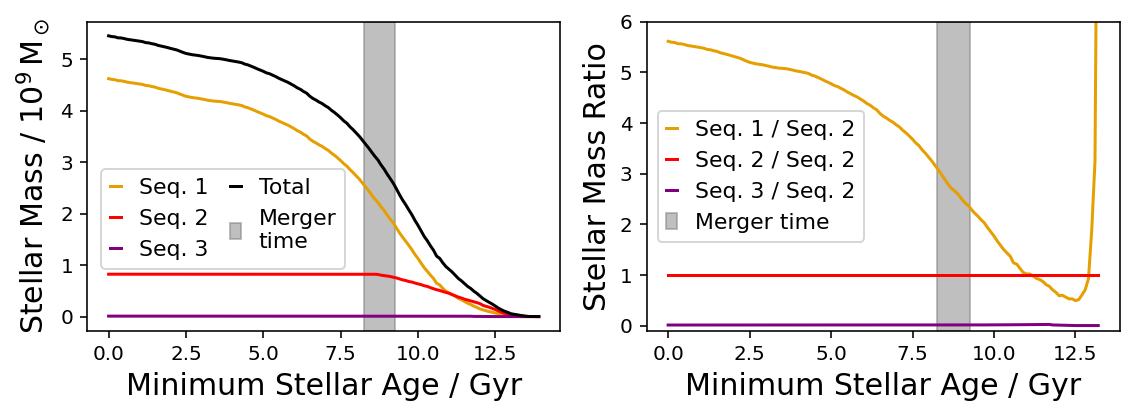

In [137]:
age_minima = np.arange(0,14,0.1)

seq1_masses = []
seq2_masses = []
seq3_masses = []
total_masses = []

colors = ['C0','r','purple']

for age_minimum in age_minima:
    
    seq1_masses.append(np.sum(sim['mass'][(age_feh_sequences['1'] & (sim['age'] > age_minimum))]))
    seq2_masses.append(np.sum(sim['mass'][(age_feh_sequences['2'] & (sim['age'] > age_minimum))]))
    seq3_masses.append(np.sum(sim['mass'][(age_feh_sequences['3'] & (sim['age'] > age_minimum))]))
    total_masses.append(np.sum(sim['mass'][sim['age'] > age_minimum]))
    

f, gs = plt.subplots(1, 2, figsize=(8,3))
ax = gs[0]
ax.plot(
    age_minima,
    np.array(seq1_masses) / 10**9,
    label = 'Seq. 1', c=colors[0]
)
ax.plot(
    age_minima,
    np.array(seq2_masses) / 10**9,
    label = 'Seq. 2', c=colors[1]
)
ax.plot(
    age_minima,
    np.array(seq3_masses) / 10**9,
    label = 'Seq. 3', c=colors[2]
)
ax.plot(
    age_minima,
    np.array(total_masses) / 10**9,
    label = 'Total',
    c = 'k'
)
ax.set_xlabel(r'Minimum Stellar Age / Gyr')
ax.set_ylabel(r'Stellar Mass / $10^9\,\mathrm{M_\odot}$')
ax.axvspan(8.25,9.25,color='grey',alpha=0.5, label='Merger\ntime')
ax.legend(fontsize=11, handlelength=0.5, ncol=2, columnspacing=1, loc = (0.03,0.2))

ax = gs[1]
ax.plot(
    age_minima,
    np.array(seq1_masses)/np.array(seq2_masses),
    label = 'Seq. 1 / Seq. 2', c=colors[0]
)
ax.plot(
    age_minima,
    np.array(seq2_masses)/np.array(seq2_masses),
    label = 'Seq. 2 / Seq. 2', c=colors[1]
)
ax.plot(
    age_minima,
    np.array(seq3_masses)/np.array(seq2_masses),
    label = 'Seq. 3 / Seq. 2', c=colors[2]
)
ax.axvspan(8.25,9.25,color='grey',alpha=0.5, label='Merger time')
ax.set_ylim(-0.1,6)
ax.set_xlabel(r'Minimum Stellar Age / Gyr')
ax.set_ylabel(r'Stellar Mass Ratio')
ax.legend(fontsize=11, handlelength=0.5)
plt.tight_layout()
plt.savefig('figures/sequence_mass_ratios.pdf',dpi=200,bbox_inches='tight')
plt.show()
plt.close()

In [135]:
(np.array(seq1_masses)/np.array(seq2_masses))[(age_minima >= 8.) & (age_minima <= 8.5)]

array([3.323739 , 3.2445874, 3.1543329, 3.0697634, 2.975511 , 2.8776364],
      dtype=float32)

## Accretion Rate in (R,z)

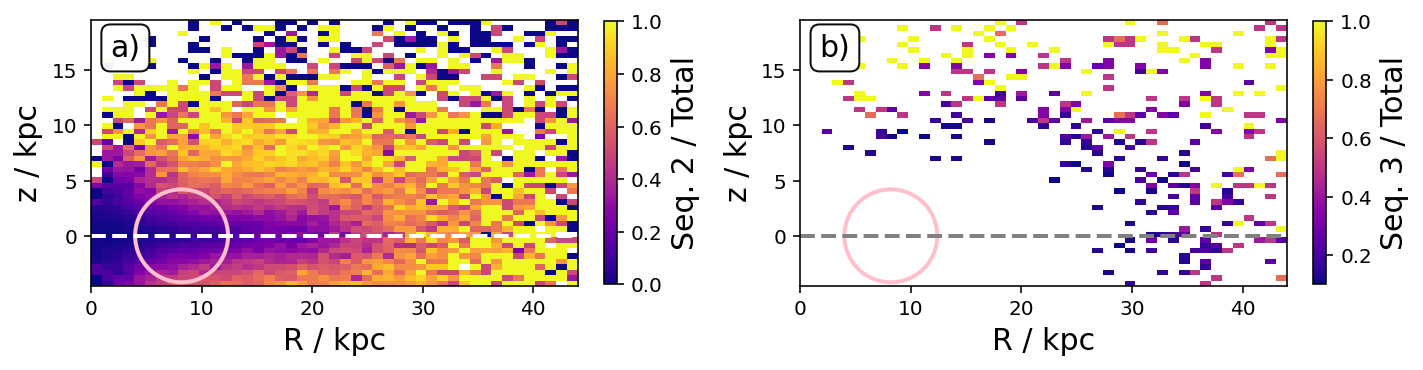

In [20]:
# Selecting the stars that are members of the topmost population of the simulated plot (BLUE)
age_feh_sequences_all = dict()

age_feh_sequences_all['1'] = (
    (sim_all['Fe_H'] > -0.2) |
    ((sim_all['Fe_H'] > -1.) & (sim_all['age'] < 7)) |
    (10**(sim_all['Fe_H']+0.35) > 2.0 - 0.15*(sim_all['age']))
)

# The middle stream - most likely accreted (RED)
age_feh_sequences_all['2'] = (
    ~ age_feh_sequences_all['1'] &
    (sim_all['age'] > 6) &
    (10**(sim_all['Fe_H']+0.45) > 1.87 - 0.15*(sim_all['age']))
)

# The bottom, small stream (PURPLE)
age_feh_sequences_all['3'] = (
    (sim_all['age'] > 10) &
    (~age_feh_sequences_all['1']) &
    (~age_feh_sequences_all['2'])
)

colors = ['C0','r','purple']
cmaps = ['Blues','Reds','Purples']

# Replicating Martig et al 
R_bin_size = 1 # kpc
z_bin_size = 0.5 # kpc

R_bins = np.arange(0,45,R_bin_size)
z_bins = np.arange(-4.5,20,z_bin_size)

accretion_rate = np.ones((len(R_bins),len(z_bins)))

for R_index,R_bin in enumerate(R_bins):
    for z_index,z_bin in enumerate(z_bins):
        nr_in_bins = len(np.where((
            (sim_all['R'] > R_bin-0.5*R_bin_size) & (sim_all['R'] < R_bin+0.5*R_bin_size) & 
            (sim_all['z'] > z_bin-0.5*z_bin_size) & (sim_all['z'] < z_bin+0.5*z_bin_size)
        ) == True)[0])
        
        nr_in_bins_and_accreted = len(np.where((
            (sim_all['R'] > R_bin-0.5*R_bin_size) & (sim_all['R'] < R_bin+0.5*R_bin_size) & 
            (sim_all['z'] > z_bin-0.5*z_bin_size) & (sim_all['z'] < z_bin+0.5*z_bin_size) &
            (
                age_feh_sequences_all['2']
            )
        ) == True)[0])
        try:
            accretion_rate[R_index,len(z_bins)-z_index-1] = nr_in_bins_and_accreted / nr_in_bins
        except:
            accretion_rate[R_index,len(z_bins)-z_index-1] = np.NaN


accretion_rate_3 = np.ones((len(R_bins),len(z_bins)))

for R_index,R_bin in enumerate(R_bins):
    for z_index,z_bin in enumerate(z_bins):
        nr_in_bins = len(np.where((
            (sim_all['R'] > R_bin-0.5*R_bin_size) & (sim_all['R'] < R_bin+0.5*R_bin_size) & 
            (sim_all['z'] > z_bin-0.5*z_bin_size) & (sim_all['z'] < z_bin+0.5*z_bin_size)
        ) == True)[0])
        
        nr_in_bins_and_accreted = len(np.where((
            (sim_all['R'] > R_bin-0.5*R_bin_size) & (sim_all['R'] < R_bin+0.5*R_bin_size) & 
            (sim_all['z'] > z_bin-0.5*z_bin_size) & (sim_all['z'] < z_bin+0.5*z_bin_size) &
            (
                age_feh_sequences_all['3']
            )
        ) == True)[0])
        try:
            accretion_rate_3[R_index,len(z_bins)-z_index-1] = nr_in_bins_and_accreted / nr_in_bins
        except:
            accretion_rate_3[R_index,len(z_bins)-z_index-1] = np.NaN

accretion_rate_3[accretion_rate_3 < 0.1] = np.nan

f, gs = plt.subplots(1,2,figsize=(10,8))

ax = gs[0]
ax.text(0.04,0.95,panels[0],fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
s = ax.imshow(accretion_rate.T,extent=(R_bins[0],R_bins[-1],z_bins[0],z_bins[-1]), aspect=1, cmap='plasma')
c = plt.colorbar(s, ax=ax, fraction=0.025)
c.set_label('Seq. 2 / Total')
ax.set_xlabel('R / kpc')
ax.axhline(0,lw=2,color='w',ls='dashed')
ax.set_ylabel('z / kpc')

circle = matplotlib.patches.Circle( (r_solar, 0.0), radius=radius, lw=2, fill=False, edgecolor='pink')
ax.add_patch(circle)

ax = gs[1]
ax.text(0.04,0.95,panels[1],fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
s = ax.imshow(accretion_rate_3.T,extent=(R_bins[0],R_bins[-1],z_bins[0],z_bins[-1]), aspect=1, cmap='plasma')
c = plt.colorbar(s, ax=ax, fraction=0.025)
c.set_label('Seq. 3 / Total')
ax.set_xlabel('R / kpc')
ax.axhline(0,lw=2,color='grey',ls='dashed')
ax.set_ylabel('z / kpc')

circle = matplotlib.patches.Circle( (r_solar, 0.0), radius=radius, lw=2, fill=False, edgecolor='pink')
ax.add_patch(circle)

plt.tight_layout()
plt.savefig('figures/accretion_rates.pdf',dpi=200,bbox_inches='tight')
plt.show()
plt.close()